New stis data!!!

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [59]:
path = '/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/'
x1ds = glob.glob('{}*x1d.fits'.format(path))

In [60]:
#reordering to make sense with previous work

x1ds = ['/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua1010_x1d.fits',
        '/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua2010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua4010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehub3010_x1d.fits']

1194.5680219305061 1249.0926837505228


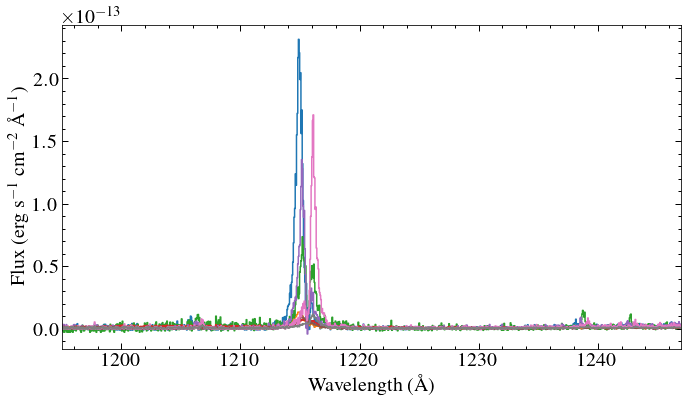

In [61]:
plt.figure(figsize=(10,6))
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'])
    plt.step(data['WAVELENGTH'],data['ERROR'])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.xlim(1195, 1247)
# plt.savefig('plots/1st_look.png', dpi=150)
print(data['WAVELENGTH'][0], data['WAVELENGTH'][-1])

(-1e-15, 1e-14)

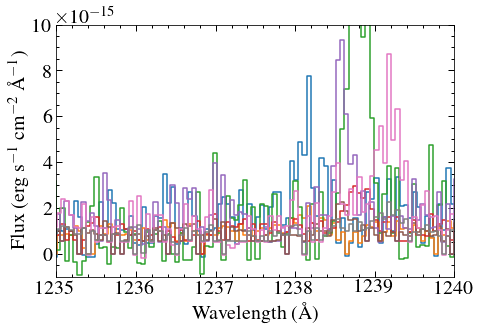

In [62]:
plt.figure(figsize=(7,5))
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'])
    plt.step(data['WAVELENGTH'],data['ERROR'])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.xlim(1235, 1240)
plt.ylim(-0.1e-14, 1e-14)

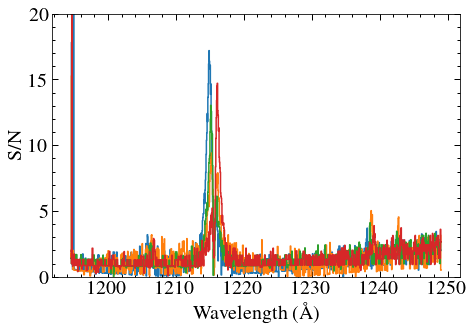

In [63]:
plt.figure(figsize=(7,5))
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    mask = (data['FLUX'] > 0)
    plt.step(data['WAVELENGTH'][mask],abs(data['FLUX'][mask]/data['ERROR'][mask]))
    
plt.xlabel('Wavelength (\AA)')
plt.ylabel('S/N')
plt.ylim(0, 20)
plt.tight_layout()

In [64]:
# Si III,1206.499,High,4.8
# N V,1238.821,High,5.3
# N V,1242.804,High,5.3

In [65]:
lines = [1206.499, 1238.821, 1242.804]
names = ['Si\,{\sc iii}', 'N\,{\sc v}', 'N\,{\sc v}']
fitter = fitting.LevMarLSQFitter()
lya = 1215.67

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
              c0                     c1                     c2          
    ---------------------- ---------------------- ----------------------
    2.5321493455784073e-12 -4.171764250869352e-15 1.7185400064818167e-18


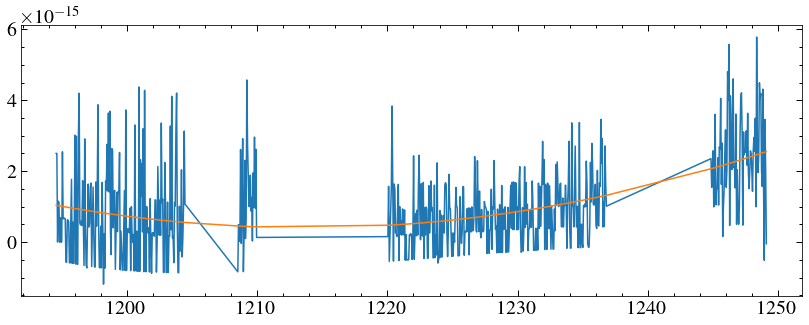

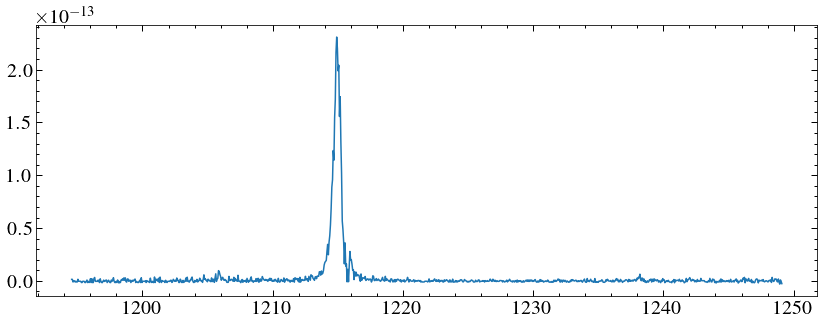

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
              c0                     c1                     c2         
    ---------------------- ---------------------- ---------------------
    1.1456441367860112e-12 -1.891696725446824e-15 7.813173794936041e-19


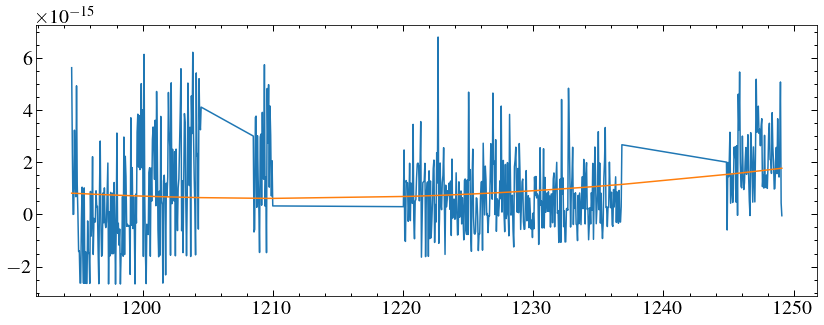

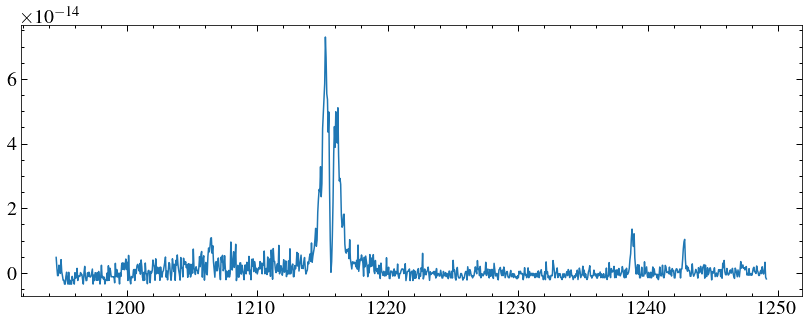

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
              c0                    c1                     c2          
    --------------------- ---------------------- ----------------------
    3.239745364540608e-12 -5.335002094825839e-15 2.1965228287586254e-18


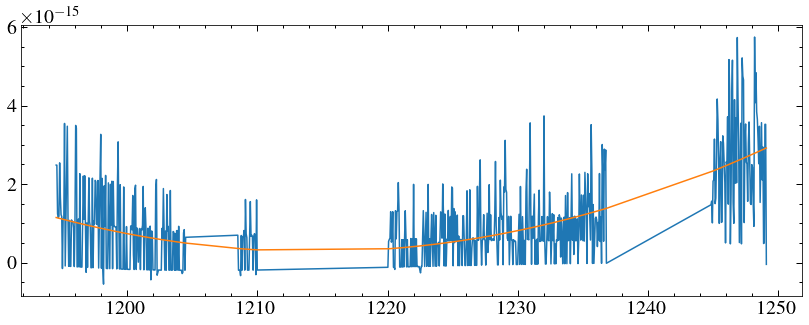

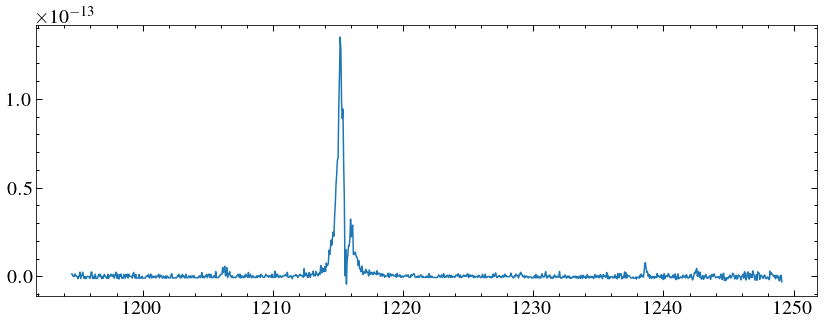

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
             c0                    c1                     c2          
    -------------------- ---------------------- ----------------------
    2.84323381854815e-12 -4.680808651079845e-15 1.9267899327605054e-18


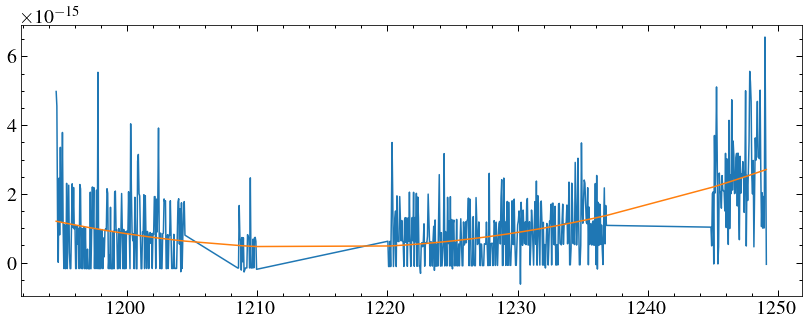

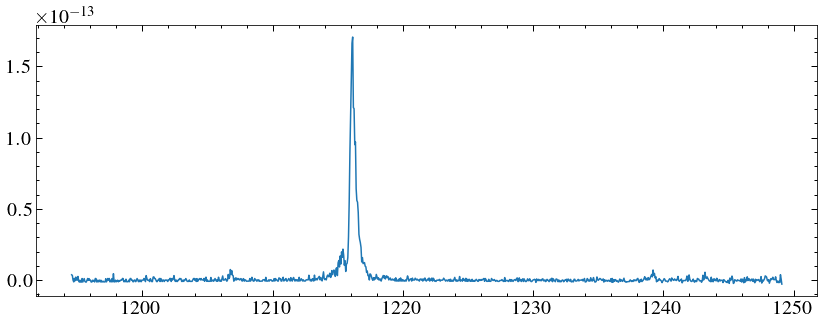

In [66]:
#cleaning off the WD spectrum, use a ploynomial rather than a model 
for i, x in enumerate(x1ds):
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    stis_mask = (w < lines[0]-2) | (w > lines[0]+2) & (w < 1210) | (w > 1220) & (w < lines[1]-2) | (w > lines[1]+2) & (w < lines[2]-2) | (w > lines[2]+2) 
    wi, fi, ei = w[stis_mask], f[stis_mask], e[stis_mask]
    poly_init = models.Polynomial1D(2)
    poly_fit =  fitting.LinearLSQFitter()(poly_init, wi, fi)#, weights = 1/ei)
    print(poly_fit)
    plt.plot(wi, fi)
    plt.plot(wi, poly_fit(wi))
    #plt.plot(wi, ei)
    plt.show()
    plt.plot(w, f-poly_fit(w))
    plt.show()



oehua1010
-148.40+/-6.44
-157.72+/-8.74
-185.56+/-13.95


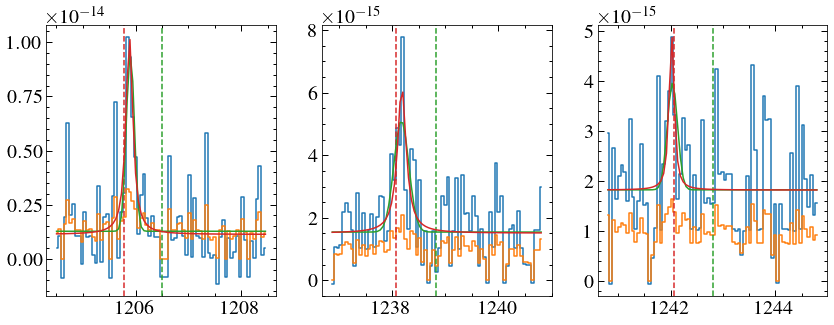

-155.79399118400354 8.36077897235921
oehua2010
-18.98+/-9.27
-1.36+/-3.31
-5.50+/-3.57


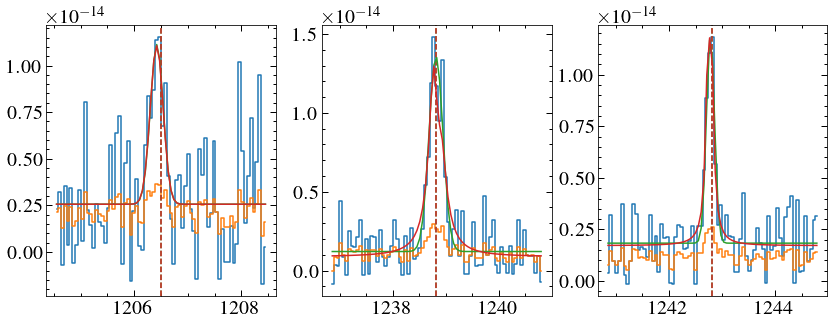

-4.277688571197301 3.0656876397830417
oehua4010
-54.79+/-9.11
-46.66+/-3.97
-62.51+/-9.06


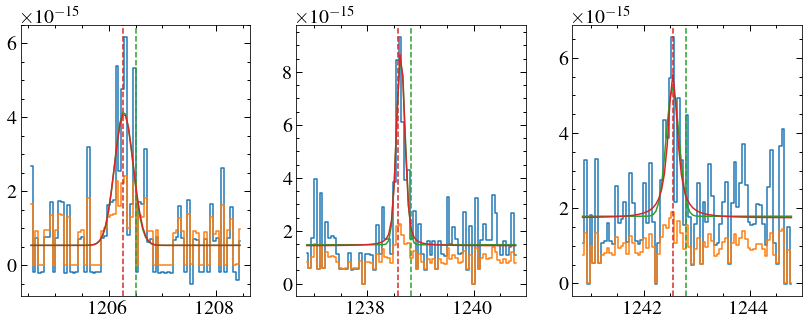

-49.976484824923084 4.060415959976437
oehub3010
75.80+/-5.46
90.50+/-5.67
102.78+/-7.63


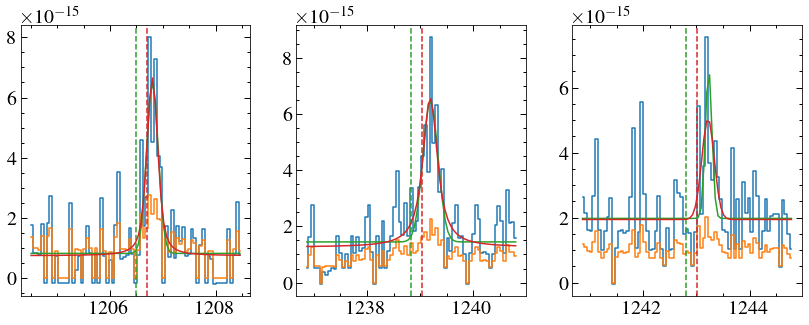

87.05421318527958 7.3597464351489625


In [67]:
def gauss_flux(amp, std, off, ae, se, oe):
    """
    Calcualates the flux and error of a Gaussian with amplitude and stddev amp and std, with offset off
    """
    off_err = 0
    if off != 0.0:
        amp += (-1*off)
        off_err = (oe/off)**2
        
    flux = ((2*np.pi)**0.5) * amp * std
    error = flux * (((ae/amp)**2)+((se/std)**2)+off_err)**0.5
    return flux, error



def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error

deltavs = []
deltav_errs = []

line_fluxes = np.ndarray(shape=(len(x1ds), len(lines)))
line_errors = np.ndarray(shape=(len(x1ds), len(lines)))

line_dvs = np.ndarray(shape=(len(x1ds), len(lines)))
line_dves = np.ndarray(shape=(len(x1ds), len(lines)))

line_stds = np.ndarray(shape=(len(x1ds), len(lines)))
line_stdes = np.ndarray(shape=(len(x1ds), len(lines)))


dates = []
v_helios = []

exptimes = []

guess_dv = np.array([-180, 0, -60, 50])*u.km/u.s
for i, x in enumerate(x1ds):
    data = fits.getdata(x, 1)[0]
    hdr = fits.getheader(x, 1)
    print(hdr['ROOTNAME'])
    tstart, tend = (hdr['EXPSTART']), (hdr['EXPEND']) #mjd
    exptimes.append(hdr['EXPTIME'])
    v_helios.append(hdr['V_HELIO'])
    dates.append((tstart+tend)/2)
    
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    stis_mask = (w < lines[0]-2) | (w > lines[0]+2) & (w < 1210) | (w > 1220) & (w < lines[1]-2) | (w > lines[1]+2) & (w < lines[2]-2) | (w > lines[2]+2) 
    wi, fi, ei = w[stis_mask], f[stis_mask], e[stis_mask]
    poly_init = models.Polynomial1D(2)
    poly_fit =  fitting.LinearLSQFitter()(poly_init, wi, fi)#, weights = 1/ei)
 #   f = f - poly_fit(w)
    
    dvs = []
    dves = []
    for j, line in enumerate(lines): #nv 1242 is only barely detected
        plt.subplot(1, 3, j+1)
        guess_line = guess_dv[i].to(u.AA,  equivalencies=u.doppler_optical(line*u.AA)).value
#         print(guess_line)
        mask = (w > line-2) & (w < line+2)
        wline, fline, eline = w[mask], f[mask], e[mask]
        plt.step(wline, fline, where='mid')
        plt.step(wline, eline, where='mid')
        plt.axvline(line, ls='--', c='C2')
        plt.axvline(guess_line, ls='--', c='C3')
        gg_init = models.Const1D(0)+models.Gaussian1D(1e-14, guess_line, 0.1)
        gg_fit = fitter(gg_init, wline, fline, maxiter=100000)
        
        
      #  print(gg_fit)
#         fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
       # print(fit_e)
        plt.plot(wline, gg_fit(wline))
        rest_lam = line*u.AA
        obs_lam = gg_fit[1].mean*u.AA
        # print(rest_lam, obs_lam)
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
        # print(dv)
        if type(fitter.fit_info['param_cov']) == np.ndarray:
            fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
            off, oe = gg_fit[0].amplitude, fit_e[0]
            amp, ae = gg_fit[1].amplitude, fit_e[1],
            std, se = gg_fit[1].stddev, fit_e[2]
            f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
        
            eup = (obs_lam+fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
            edo = (obs_lam-fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
            dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s    
            line_fluxes[i, j] = f_l
            line_errors[i, j] = e_l
            line_dvs[i, j] = dv.value
            line_dves[i, j] = dve.value
            line_stds[i, j] = std.value
            line_stdes[i, j] = se

            
        else:
            line_fluxes[i, j] = -1.0
            line_errors[i, j] = -1.0
            line_dvs[i, j] = -1.0
            line_dves[i, j] = -1.0
            line_stds[i, j] = -1.0
            line_stdes[i, j] = -1.0
            
        # print(dv, dve)
        print('{0:.2f}+/-{1:.2f}'.format(dv.value, dve.value))
        v_init = models.Const1D(0)+models.Voigt1D(x_0=guess_line, amplitude_L=1e-14, fwhm_L=0.1, fwhm_G=0.1)
        v_fit = fitter(v_init, wline, fline, maxiter=100000)
        plt.plot(wline, v_fit(wline))
        
      # 
        
#         obs_line = gg_fit[1].mean.value*u.AA
#         dv = obs_line.to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
#        # print(fit_e)
#         eup = (obs_line+fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
#         edo = (obs_line-fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
#         dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s
# #         print(dv, dve)
#         dvs.append(dv.value)
#         dves.append(dve.value)
        
#         line_flux, line_fluxerr = gauss_flux(gg_fit[1].amplitude, gg_fit[1].stddev, gg_fit[0].amplitude, fit_e[1], fit_e[3], fit_e[0])
#        # print(line_flux, line_fluxerr)
#         line_fluxes[i, j] = line_flux
#         line_errors[i, j] = line_fluxerr
#         line_dvs[i, j] = dv.value
#         line_dves[i, j] = dve.value
      #  print(line_fluxes) 
    plt.show()
    dv_spec, dve_spec = dv_average(line_dvs[i][line_dvs[i]!=-1.0], line_dves[i][line_dvs[i]!=-1.0])
    deltavs.append(dv_spec)
    deltav_errs.append(dve_spec)
    print(dv_spec, dve_spec)
       
dates, deltavs, deltav_errs = np.array(dates), np.array(deltavs), np.array(deltav_errs)
     

59306


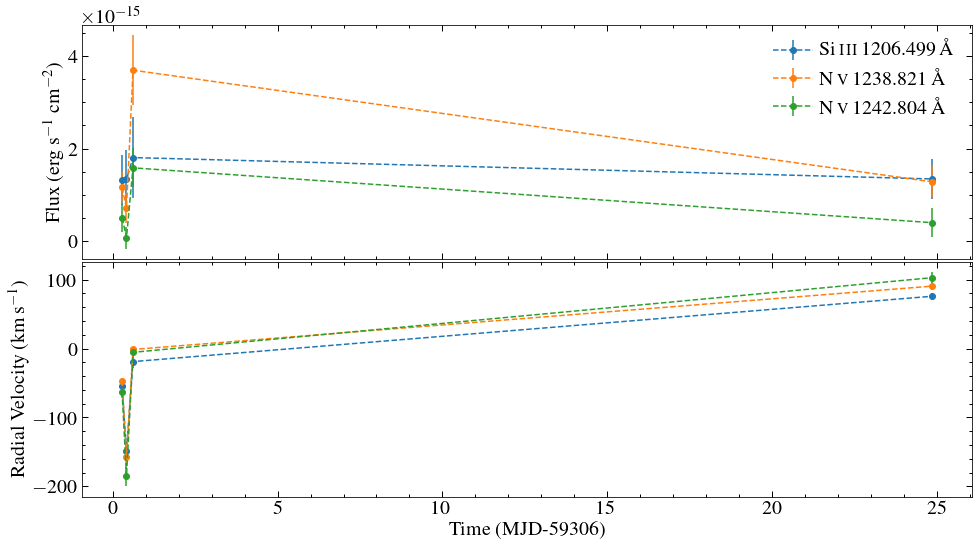

In [68]:
import math as mt
# print(line_fluxes)
# print(line_fluxes[:,0])
plt.figure(figsize=(14,8))

args = np.argsort(dates)
day = mt.floor(np.min(dates))
print(day)
plt.subplot(211)

for i in range(len(lines)):
    plt.errorbar(dates[args]-day, line_fluxes[:,i][args], yerr=line_errors[:,i][args], ls='--', marker='o', label = '{}\,{}\,\AA'.format(names[i], lines[i]))
plt.legend()
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
plt.xticks(visible=False)

plt.subplot(212)
for i in range(len(lines)):
    plt.errorbar(dates[args]-day, line_dvs[:,i][args], yerr=line_dves[:,i][args], ls='--', marker='o', label = '{}\,{}\,\AA'.format(names[i], lines[i]))
# plt.legend()
plt.xlabel('Time (MJD-{})'.format(day))
plt.ylabel('Radial Velocity (km\,s$^{-1}$)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)

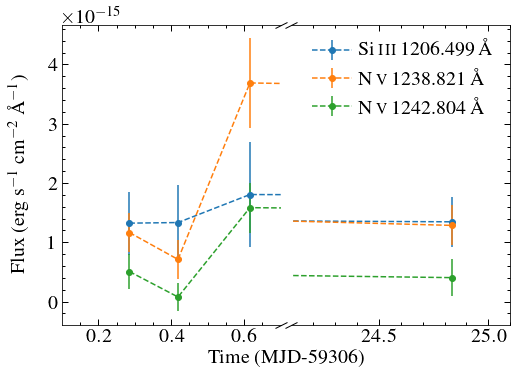

In [69]:
np.random.seed(19680801)

pts = np.random.rand(30)*.2
# Now let's make two outlier points which are far away from everything.
# pts[[3, 14]] += .8



# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax1) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,6))
fig.subplots_adjust(hspace=0.03)  # adjust space between axes

# plot the same data on both axes
# ax1.plot(pts)
# ax2.plot(pts)

for i in range(len(lines)):
    ax1.errorbar(dates[args]-day, line_fluxes[:,i][args], yerr=line_errors[:,i][args], ls='--', marker='o', label = '{}\,{}\,\AA'.format(names[i], lines[i]))
    ax2.errorbar(dates[args]-day, line_fluxes[:,i][args], yerr=line_errors[:,i][args], ls='--', marker='o', label = '{}\,{}\,\AA'.format(names[i], lines[i]))
ax2.legend()
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
# plt.xticks(visible=False)

# zoom-in / limit the view to different portions of the data
ax1.set_xlim(0.1, 0.7)  # outliers only
ax2.set_xlim(24.1, 25.1)  # most of the data

# hide the spines between ax and ax2
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)  # don't put tick labels at the top
ax2.yaxis.tick_right()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [1, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlabel('Time (MJD-{})'.format(day))
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)  # adjust space between axes


# plt.show()

plt.savefig('plots/stis_line_strength.png', dpi=150, facecolor='w')
plt.savefig('plots/stis_line_strength.pdf', dpi=150)



In [70]:
lyatab = Table.read('EGUMa_LyA_ISM_estimate.txt', format='ascii.basic')


/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua1010_x1d.fits -152
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua2010_x1d.fits -3
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua4010_x1d.fits -48.0
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehub3010_x1d.fits 87.0


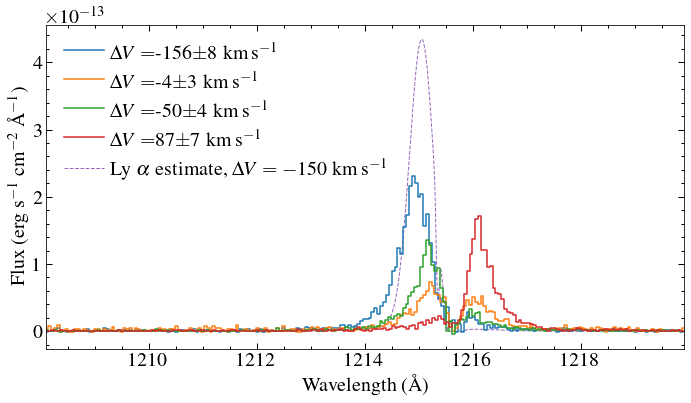

In [71]:
dv_labs = [-152,-3, -48.0, 87.0]
dve_labs = [3.5, 5, 3.0, 7.4]

plt.figure(figsize=(10,6))
for i, x in enumerate(x1ds):
    print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'], label = r'$\Delta V = ${0:.0f}$\pm${1:.0f}'.format(deltavs[i], deltav_errs[i]) +' km\,s$^{-1}$')
plt.plot(lyatab['wave'], lyatab['flux_-150kms']*lyatab['ISM_attenuation'], label=r'Ly $\alpha$ estimate, $\Delta V = -150$ km\,s$^{-1}$', c='C4', lw=1, ls='--', zorder=-1)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(loc=2)
plt.xlim(1208.1, 1219.9)
plt.tight_layout()
# plt.savefig('plots/1st_look_model.png', dpi=150)

In [72]:
# lyatab

Compare with COS

/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


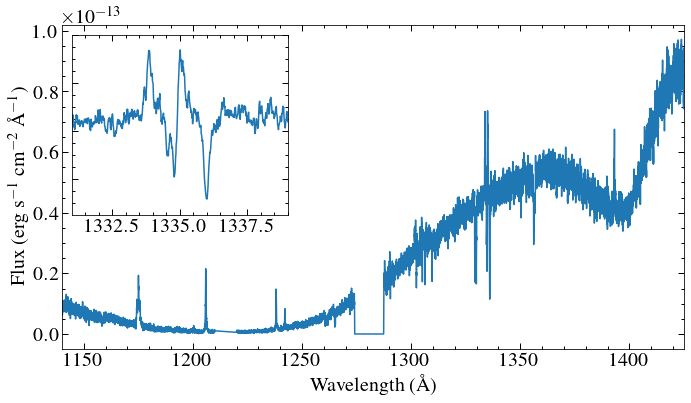

In [73]:
cpath = '/media/david/2tb_ext_hd/hddata/eg_uma/hst/cos/'
cx = glob.glob('{}*x1dsum.fits'.format(cpath))[0]

smooth=5
data = fits.getdata(cx, 1)
wc = np.array([], dtype=float)
fc = np.array([], dtype=float)
ec = np.array([], dtype=float)
for dt in data[::-1]:
    wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
    mask = (dq==0)
    wi, fi, ei = wi[mask], fi[mask], ei[mask]
    wc = np.concatenate((wc, wi))
    fc = np.concatenate((fc, fi))
    ec = np.concatenate((ec, ei))    

fc = convolve(fc,Box1DKernel(smooth))
ec = convolve(ec,Box1DKernel(smooth))/(smooth**0.5)

# plt.plot(wc, fc)

fig, ax = plt.subplots(figsize=(10, 6))
mask = (wc > 1140) & (wc < 1210) | (wc > 1220) &(wc < 1425)
wc1, fc1, ec1 = wc[mask], fc[mask], ec[mask]
plt.plot(wc1, fc1)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlim(1140, 1425)

axins = inset_axes(ax, width=3, height=2.5, loc = 2)
axins.plot(wc1, fc1)
axins.set_xlim(1331, 1339)
axins.set_ylim(0.05e-13,0.8e-13)
axins.set_yticklabels([],visible=False)


plt.tight_layout()
plt.savefig('plots/eg_uma_cos.png', dpi=150,facecolor='w')

In [74]:
data = fits.getdata(x1ds[0])[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']

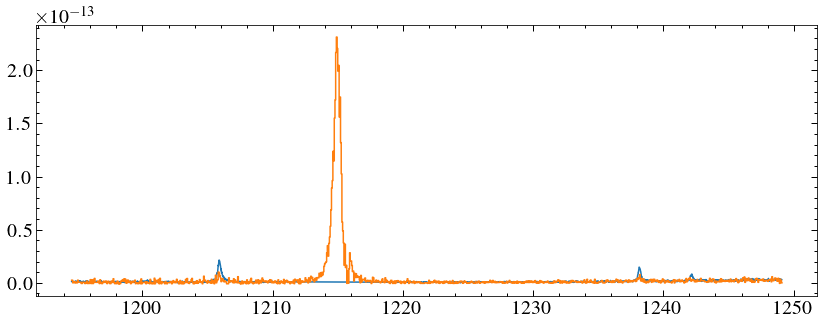

In [75]:
mask = (wc1 > ws[0]) & (wc1 < ws[-1])
plt.plot(wc1[mask], fc1[mask])
plt.step(ws, fs, where='mid')

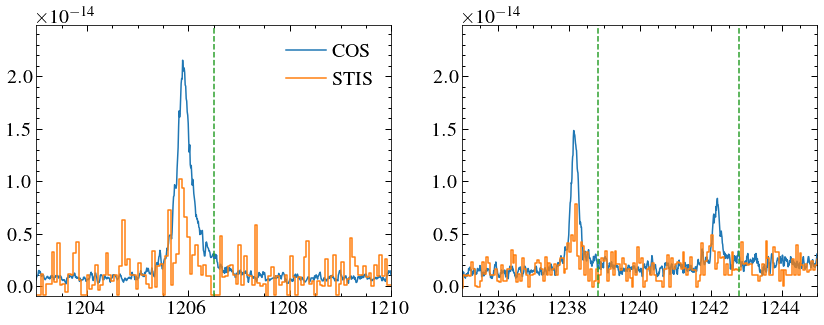

In [76]:
plt.subplot(121)
plt.plot(wc1[mask], fc1[mask], label='COS')
plt.step(ws, fs, where='mid', label='STIS')
plt.xlim(1203, 1210)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]
plt.legend()

plt.subplot(122)
plt.plot(wc1[mask], fc1[mask])
plt.step(ws, fs, where='mid')
plt.xlim(1235, 1245)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]

Is the COS and STIS wd flux consitant? 

oehua1010
6.358249251013486e-14
4.90345270092245e-14
0.7711954198934328


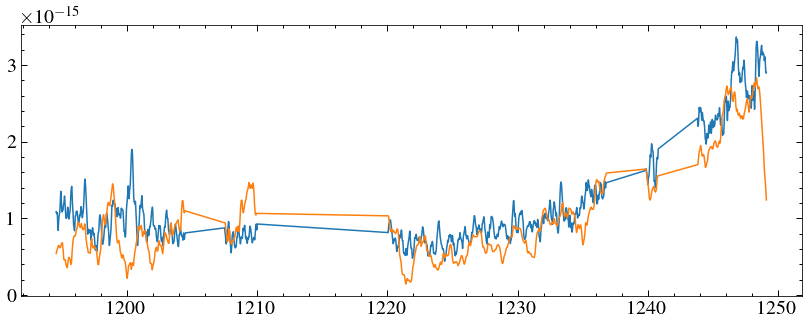

oehua2010
6.356524134796955e-14
5.4000948528360054e-14
0.8495358057833441


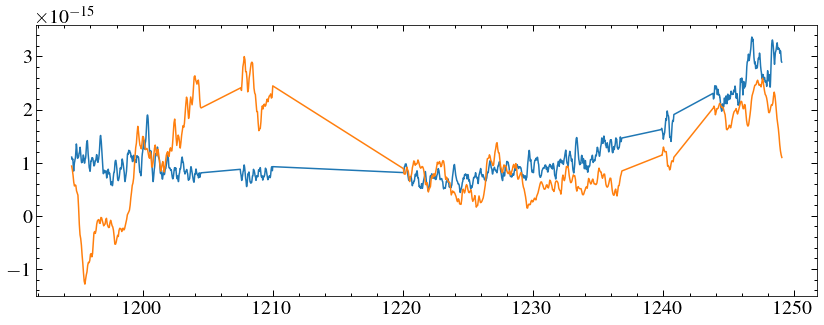

oehua4010
6.356524134796955e-14
4.47874618660375e-14
0.7045904478024629


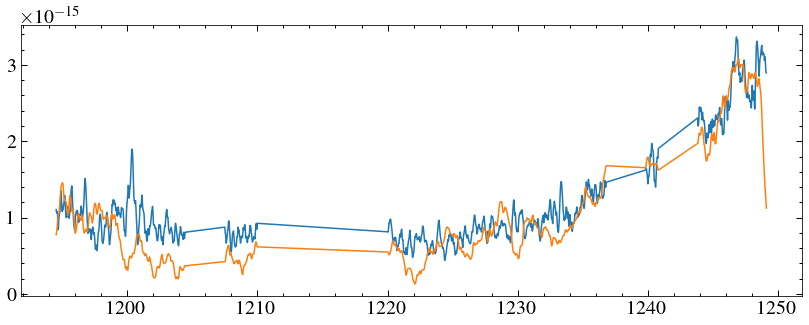

oehub3010
6.356759148008947e-14
4.982754198478589e-14
0.7838513435009219


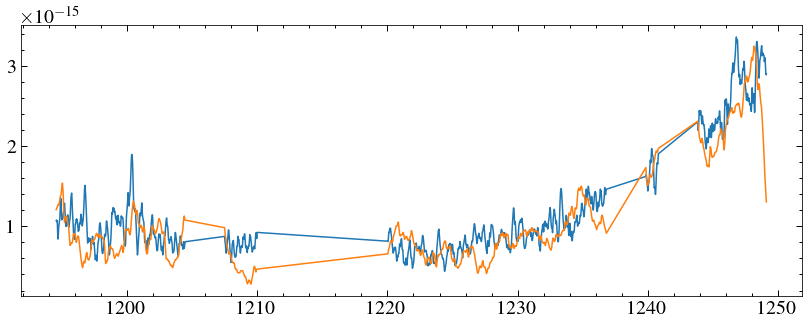

In [122]:
lines = [1206.499, 1238.821, 1242.804]


for i, x in enumerate(x1ds):
    data = fits.getdata(x, 1)[0]
    hdr = fits.getheader(x, 1)
    print(hdr['ROOTNAME'])
    ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']

    cos_mask = (wc >= ws[0]) & (wc < lines[0]-2) | (wc > lines[0]+1) & (wc < 1210) | (wc > 1220) & (wc < lines[1]-2) | (wc > lines[1]+1) & (wc < lines[2]-2) | (wc > lines[2]+1) & (wc <=ws[-1])
    fci = convolve(fc,Box1DKernel(20))
    plt.plot(wc[cos_mask], fci[cos_mask])
    cos_int = np.trapz(fc[cos_mask], wc[cos_mask])
    print(cos_int)
    stis_mask = (ws < lines[0]-2) | (ws > lines[0]+1) & (ws < 1210) | (ws > 1220) & (ws < lines[1]-2) | (ws > lines[1]+1) & (ws < lines[2]-2) | (ws > lines[2]+1) 

    fsi = convolve(fs,Box1DKernel(20))
    plt.plot(ws[stis_mask], fsi[stis_mask])

    stis_int = np.trapz(fs[stis_mask], ws[stis_mask])

    print(stis_int)

    print(stis_int/cos_int)
    plt.show()

Where are they in phase space?

2458093.22951347 2458093.25927032
-138.6352434900658 2.11867788687639


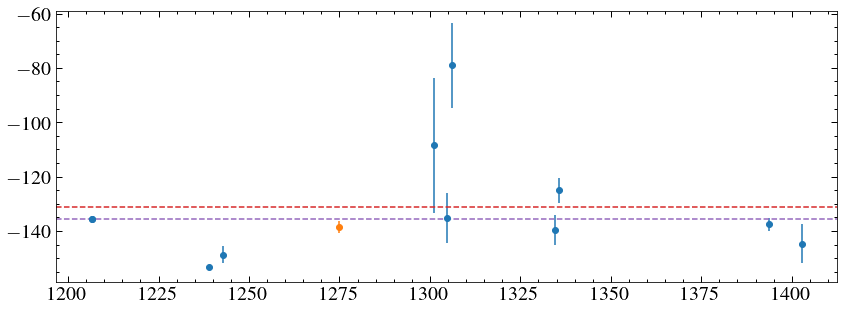

In [78]:
#loading the COS RVs as another point
coslines = Table.read('eg_uma_line_fluxes.ecsv')
mask = (coslines['ION'] != 'C III') & (coslines['FLUX'] != -1.0)
coslines = coslines[mask]
chdr = fits.getheader(cx, 1)
cstart, cend = chdr['EXPSTRTJ'], chdr['EXPENDJ']
print(cstart, cend)
# chdr

cdv, cdve = dv_average(coslines['VELOCITY'], coslines['VELOCITY_ERROR'])
print(cdv, cdve)
plt.errorbar(coslines['WAVELENGTH'], coslines['VELOCITY'], yerr=coslines['VELOCITY_ERROR'], ls='none', marker='o')
plt.errorbar(1275, cdv, yerr=cdve, ls='none', marker='o')
plt.axhline(np.mean(coslines['VELOCITY']), ls='--', c='C3')
plt.axhline(np.median(coslines['VELOCITY']), ls='--', c='C4')

/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)


-4.1725699699372 km / s
18.42792150310619 km / s
-18.390007099644205 km / s
-3.7132875609584346 km / s
[2459306.92166367, 2459307.118970779, 2459306.7881967495, 2459331.334035227]
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=124.5, frequency=1., phase=0.43646892)>

    [1]: <Const1D(amplitude=-27.04049035)>
Parameters:
    amplitude_0 frequency_0      phase_0          amplitude_1    
    ----------- ----------- ------------------ ------------------
          124.5         1.0 0.4364689174556685 -27.04049034766734


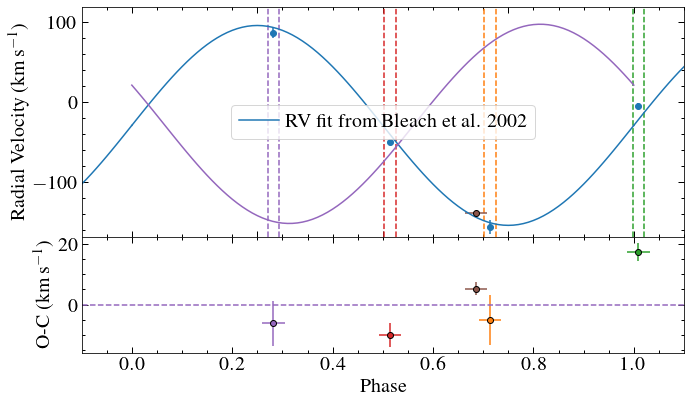

In [79]:
#https://ui.adsabs.harvard.edu/#abs/2000MNRAS.312...70B/abstract
gamma = -29.0*u.km/u.s
gamma_e = 4.8*u.km/u.s
k2 = 124.9*u.km/u.s
# k2 = 126.0*u.km/u.s # (2.5)
k2_e = 0.4*u.km/u.s
p = 961.31*u.min
pd = 0.66757877*u.d #(54)
pd_e = 0.00000054*u.d

eph =2444279.9151*u.d #(18)

fold_error = ((0.0018*u.d/eph)**2+(0.00000054*u.d/pd)**2)*0.05

k2_range = [k2-k2_e,k2+k2_e]
gamma_range = [gamma-gamma_e, gamma+gamma_e]
pday_range = np.array([(pd-pd_e).value, (pd+pd_e).value])

phase_time = np.arange(0,1.01, 0.01)
phase_orbit = models.Sine1D(k2, 1, 0)+models.Const1D(gamma)
phase_curve = phase_orbit(phase_time)

fig, ax, = plt.subplots(figsize=(10,6))
gs = GridSpec(3, 1)
phasemids = []
tmids = []


eg_uma = coord.SkyCoord(183.93308097127309, 52.51643832583794,
                        unit=(u.deg, u.deg), frame='icrs')
pole = coord.EarthLocation(0, 0,0*u.m)  
 


plt.subplot(gs[:2])
for i, x in enumerate(x1ds):
    hdr = fits.getheader(x, 1)
    tstart, tend = (hdr['EXPSTART']), (hdr['EXPEND']) #mjd
    #print(tstart, tend)
    times = time.Time([tstart, tend], format='mjd',scale='utc', location = pole) 
    ltt_helio = times.light_travel_time(eg_uma, 'heliocentric') 
    #print(times)
    #print(ltt_helio)
    tstart, tend = (times.utc + ltt_helio)[0]+2400000.5, (times.utc + ltt_helio)[1]+2400000.5  #HJD correction
    tmid = (tstart.value+tend.value)/2
    tmids.append(tmid)
   # print(tstart, tend)
    pstart, pend = ((tstart - eph)/pd).value % 1, ((tend - eph)/pd).value % 1 
    if pend < pstart:
        pend +=1
    phasemid = (pstart+pend)/2 
    phasemids.append((pstart+pend)/2)
    print(phase_orbit(pend) - phase_orbit(pstart))
    [plt.axvline(line, ls='--', c='C{}'.format(i+1)) for line in (pstart, pend)]

print(tmids)
    
plt.errorbar(phasemids, deltavs, yerr = deltav_errs, marker='o', ls='none')

    
# plt.errorbar(phasemid, cdv, yerr=cdve, xerr=[[phasemid-pstart], [pend-phasemid]], marker='o', ls='none', c='C{}'.format(len(x1ds)+1), markeredgecolor='k')

    
#cos data
times = time.Time([cstart, cend], format='jd',scale='utc', location = pole) 
ltt_helio = times.light_travel_time(eg_uma, 'heliocentric') 
tstart, tend = (times.utc + ltt_helio)[0], (times.utc + ltt_helio)[1]  #HJD correction. Note COS in JD not MJD
pstart, pend = ((tstart - eph)/pd).value % 1, ((tend - eph)/pd).value % 1 
if pend < pstart:
    pend +=1
tmid = (tstart.value+tend.value)/2
tmids.append(tmid)
phasemid = (pstart+pend)/2 
phasemids.append((pstart+pend)/2)
# print(phase_orbit(pend) - phase_orbit(pstart))
# [plt.axvline(line, ls='--', c='C{}'.format(len(x1ds)+1)) for line in (pstart, pend)]
plt.errorbar(phasemid, cdv, yerr=cdve, xerr=[[phasemid-pstart], [pend-phasemid]], marker='o', ls='none', c='C{}'.format(len(x1ds)+1), markeredgecolor='k')
    
    
plt.plot(phase_time, phase_curve, c='C0', label=('RV fit from Bleach et al. 2002'))#orbit(model_time))
plt.plot(phase_time-1, phase_curve, c='C0')#orbit(model_time))
plt.plot(phase_time+1, phase_curve, c='C0')#orbit(model_time))
plt.xlim(-0.249, 1.1)

# plt.errorbar(phasemids, deltavs, yerr=deltav_errs, xerr=phasemids*fold_error, marker='o', ls='none')
# for i in range(len(lines[:2])):
#     plt.errorbar(phasemids, line_dvs[:,i], yerr=line_dves[:,i], marker='o', ls='none', label = '{}\,{}\,\AA'.format(names[i], lines[i]))


dv_predict = phase_orbit(phasemids)
# print(deltavs)
# print(dv_predict)

#plt.axhline(0, ls='--', c='C2')

# [plt.annotate(labels[i],(obs_phases[i], labpos[i]), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none')) for i in range(len(obs_phases))]
plt.xticks((0.0, 0.25, 0.5, 0.75, 1))
plt.ylim(-169, 119)

plt.ylabel('Radial Velocity (km\,s$^{-1}$)')

plt.xticks(visible=False)

plt.xlim(-0.1, 1.1)
plt.legend(frameon=True)

# orbit = models.Sine1D(k2.value, 1, phase=0.5, fixed=dict(amplitude=True, frequency=True))+models.Const1D(gamma.value, fixed=dict(amplitude=True))
orbit = models.Sine1D(k2.value, 1, phase=0.5, bounds=dict(amplitude=k2_range), fixed=dict(frequency=True))+models.Const1D(gamma.value, bounds=dict(amplitude=gamma_range))
orbfit = fitter(orbit, phasemids[0:4], deltavs, weights=1/deltav_errs, maxiter=10000)
print(orbfit)
# phase_curve = phase_orbit(phase_time)
# orbittimes = np.linspace(0, 1, 1000)

plt.plot(phase_time, orbfit(phase_time), c='C4')



plt.subplot(gs[2:])

plt.xlim(-0.1, 1.1)
plt.xlabel('Phase')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
oc = np.append(deltavs, cdv) - dv_predict.value
for i in range(len(x1ds)+1):
    plt.errorbar(phasemids[i], oc[i], yerr=np.append(deltav_errs, cdve)[i], xerr=[[phasemid-pstart], [pend-phasemid]], marker='o', ls='none', c='C{}'.format(i+1), markeredgecolor='k')
plt.axhline(0, ls='--', c='C4')
plt.ylabel('O-C (km\,s$^{-1}$)')
# plt.savefig('plots/rv_curve.pdf', dpi=150)
# plt.savefig('plots/rv_curve.png', dpi=150)
calc_phase = phasemids

HJD correction? Don't think so? Could add the COS spectrum.

Trying without phase folding

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=124.5, frequency=1.49795057, phase=0.52345336)>

    [1]: <Const1D(amplitude=-26.51765205)>
Parameters:
    amplitude_0    frequency_0          phase_0           amplitude_1    
    ----------- ------------------ ------------------ -------------------
          124.5 1.4979505714359371 0.5234533599601179 -26.517652047544118
[5.78270892e+00 3.26126996e-03 2.34180138e+00]
[-150.23069613   -4.9952748   -51.51103818   91.73768901]


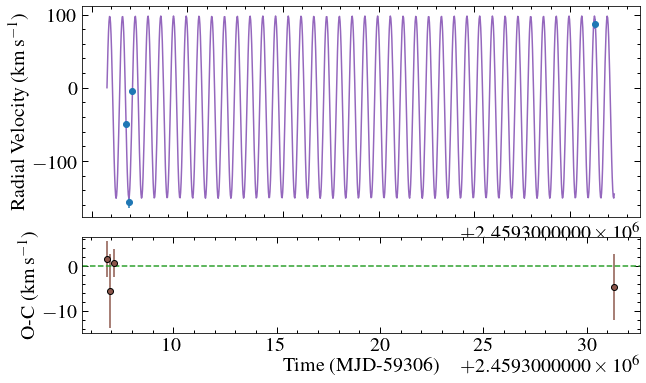

[0.73209581 0.02765211 0.53216896 0.30062173]
oehua1010_x1d.fits -155.79399118400354 8.36077897235921 0.7320958096534014 2.071136601894339 0.37021188696862084
oehua2010_x1d.fits -4.277688571197301 3.0656876397830417 0.027652106247842312 18.12203031518478 0.0660114519449769
oehua4010_x1d.fits -49.976484824923084 4.060415959976437 0.53216896019876 18.02454631123709 0.07683628893899311
oehub3010_x1d.fits 87.05421318527958 7.3597464351489625 0.30062173400074244 5.755590629838255 0.3592447067152131


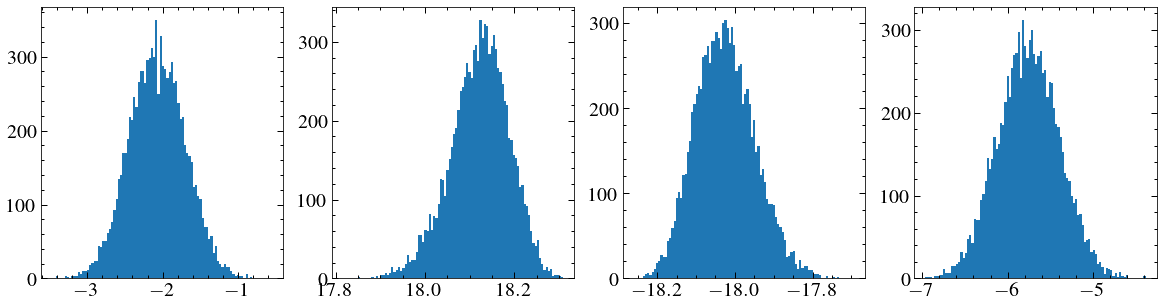

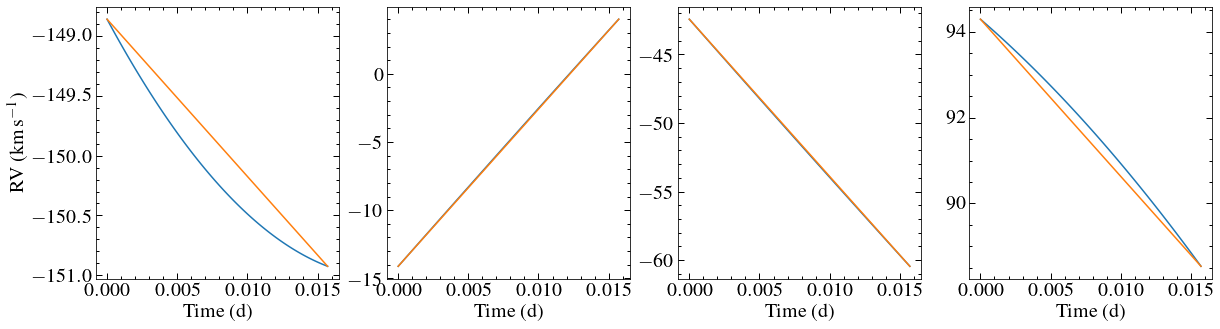

In [80]:
fig, ax, = plt.subplots(figsize=(10,6), sharex=True)
gs = GridSpec(3, 1)

plt.subplot(gs[:2])


plt.errorbar(tmids[0:4], deltavs, yerr = deltav_errs, marker='o', ls='none')
orbit = models.Sine1D(k2.value, 1/(pd.value), phase=0.5, bounds=dict(amplitude=k2_range), fixed=dict(frequency=True))+models.Const1D(gamma.value, bounds=dict(amplitude=gamma_range))
# orbit = models.Sine1D(k2.value, 1/(pd.value), phase=0.5, bounds=dict(amplitude=k2_range, frequency=(1/pday_range[::-1])))+models.Const1D(gamma.value, bounds=dict(amplitude=gamma_range))
plottime = np.linspace(min(tmids[0:4])-1, max(tmids[0:4])+1, 1000)

orbfit = fitter(orbit, tmids[0:4], deltavs, weights=1/deltav_errs, maxiter=10000, acc=0.1)
print(orbfit)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)
# phase_curve = phase_orbit(phase_time)
# orbittimes = np.linspace(0, 1, 1000)

plt.plot(plottime, orbfit(plottime), c='C4')

plt.ylabel('Radial Velocity (km\,s$^{-1}$)')

plt.xticks(visible=False)

# plt.xlim(, 24.9)
# plt.show()
plt.subplot(gs[2:])

dv_predict = orbfit(tmids[0:4])
print(dv_predict)

plt.errorbar(tmids[0:4], deltavs-dv_predict, yerr=deltav_errs, marker='o', ls='none', c='C{}'.format(i+1), markeredgecolor='k')
plt.axhline(0, ls ='--', c='C2')



plt.ylabel('O-C (km\,s$^{-1}$)')
plt.xlabel('Time (MJD-{})'.format(day))


plt.show()

plt.figure(figsize = (20, 5))

fit_phase = ((np.array(tmids[0:4])*orbfit[0].frequency.value) +orbfit[0].phase) %1
print(fit_phase)
fit_phase_e = np.full(len(tmids[0:4]), fit_e[1])

dsmear = [] #doppler broadending of each spectrum
dsmear_e = []

for i, x in enumerate(x1ds):
    plt.subplot(1,4,i+1)
    phasex = fit_phase[i]-orbfit[0].phase
    # print(phasex)
    # print (phasex/orbfit[0].frequency.value)
    # print(orbfit(phasex/orbfit[0].frequency.value))
    phasex_e = fit_phase_e[i]
    phase_dist = np.random.normal(phasex, phasex_e, 10000)
    smears = []
    for p in phase_dist:
        tp = (p/orbfit[0].frequency.value)
        # print(tp)
        t0 = tp -0.5*(exptimes[i]*u.s.to(u.d))
        t1 = tp +0.5*(exptimes[i]*u.s.to(u.d))
        dv0 = orbfit(t0)
        dv1 = orbfit(t1)
        smear = dv1-dv0
        smears.append(smear)
    plt.hist(smears, bins=100)
    smearx = abs(np.mean(smears))
    smearx_e = np.std(smears)
    print(os.path.split(x)[1], deltavs[i], deltav_errs[i], fit_phase[i], smearx, smearx_e)
    dsmear.append(smearx)
    dsmear_e.append(smearx_e)
plt.show()


plt.figure(figsize = (20, 5))


for i, x in enumerate(x1ds):
    plt.subplot(1,4,i+1)
    p = fit_phase[i]-orbfit[0].phase
    tp = (p/orbfit[0].frequency.value)
    t0 = tp -0.5*(exptimes[i]*u.s.to(u.d))
    t1 = tp +0.5*(exptimes[i]*u.s.to(u.d))
    exprange = np.linspace(t0, t1, 100)
    dv0 = orbfit(t0)
    dv1 = orbfit(t1)
    plt.plot(exprange-t0, orbfit(exprange))
    plt.plot([t0-t0, t1-t0], [dv0, dv1])
    plt.xlabel('Time (d)')
    if i == 0:
        plt.ylabel('RV (km\,s$^{-1}$)')

plt.show()   


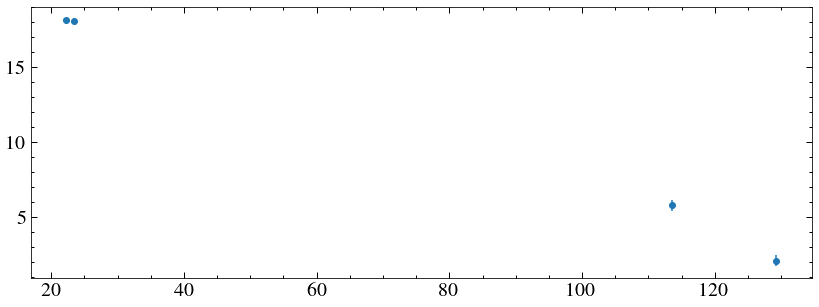

In [81]:
plt.errorbar(abs(deltavs-orbfit[1].amplitude), dsmear, yerr=dsmear_e, marker='o', ls='none')
plt.show()
# plt.errorbar(abs(deltavs-orbfit[1].amplitude), np.mean(line_stds, axis=1), yerr=np.mean(line_stdes**2, axis=1)**0.5, marker='o', ls='none')


In [82]:
phasemids #constiant with fit above, need errors

[0.7137105041292671,
 1.0092668011129717,
 0.5137836548110499,
 0.2822364291332633,
 0.6859488832033094]

Light curves have been made, don't show anything but can make a nice plot.

In [83]:
lcs = glob.glob('lc_output/*100s_lc.ecsv')
lcs

[]

In [84]:
"""plt.figure(figsize=(len(lcs)*5, 5))

for i, lc in enumerate(lcs):
    #plt.subplot(1, len(lcs), i+1)
    data= Table.read(lc)
    t,f,e = data['TIME'], data['FLUX'], data['ERROR']
    plt.errorbar(t-day, f, yerr = e, marker='o', ls='none') #plot the light curve
    #if i == 0:
plt.ylabel('Counts (s$^{-1})$')
    #if i == 1:
plt.xlabel('Time (MJD-{})'.format(day))
#plt.ylim(0.1*min(f), 2*max(f))
plt.tight_layout()"""

"plt.figure(figsize=(len(lcs)*5, 5))\n\nfor i, lc in enumerate(lcs):\n    #plt.subplot(1, len(lcs), i+1)\n    data= Table.read(lc)\n    t,f,e = data['TIME'], data['FLUX'], data['ERROR']\n    plt.errorbar(t-day, f, yerr = e, marker='o', ls='none') #plot the light curve\n    #if i == 0:\nplt.ylabel('Counts (s$^{-1})$')\n    #if i == 1:\nplt.xlabel('Time (MJD-{})'.format(day))\n#plt.ylim(0.1*min(f), 2*max(f))\nplt.tight_layout()"

In [85]:
#barycorr

In [86]:
from astropy import time, coordinates as coord, units as u
ip_peg = coord.SkyCoord("23:23:08.55", "+18:24:59.3",
                        unit=(u.hourangle, u.deg), frame='icrs')
pole = coord.EarthLocation(0, 0,0*u.m)  
times = time.Time([56325.95833333, 56325.978254], format='mjd',
                  scale='utc', location = pole)  
ltt_bary = times.light_travel_time(ip_peg)  
print(ltt_bary) 

ltt_helio = times.light_travel_time(ip_peg, 'heliocentric') 
print(ltt_helio) 

[-0.00377162 -0.00377298]
[-0.00376588 -0.00376724]


In [87]:
ltt_helio.value[0]

-0.003765875525078968

/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua1010_x1d.fits -152
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua2010_x1d.fits -3
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua4010_x1d.fits -48.0
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehub3010_x1d.fits 87.0


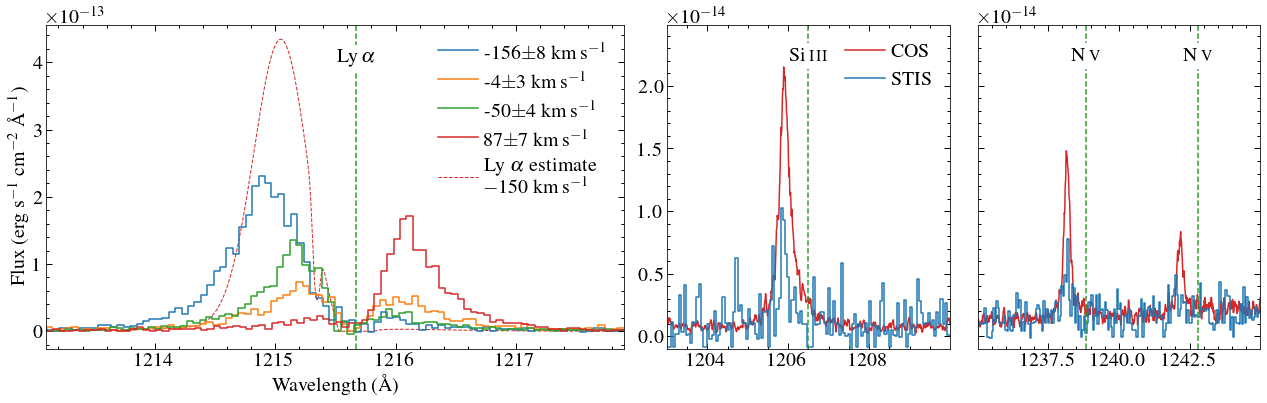

In [88]:
dv_labs = [-152,-3, -48.0, 87.0]
dve_labs = [3.5, 5, 3.0, 7.4]


plt.figure(figsize=(18,6))
plt.subplot(121)
for i, x in enumerate(x1ds):
    print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    plt.step(data['WAVELENGTH'],data['FLUX'], label = r' {0:.0f}$\pm${1:.0f}'.format(deltavs[i], deltav_errs[i]) +' km\,s$^{-1}$')
plt.plot(lyatab['wave'], lyatab['flux_-150kms']*lyatab['ISM_attenuation'], label=r'Ly $\alpha$ estimate'+'\n'+'$ -150$ km\,s$^{-1}$', c='C3', lw=1, ls='--', zorder=-1)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(loc=1)
plt.xlim(1213.1, 1217.9)
plt.axvline(lya, c='C2', ls='--')
plt.annotate(r'Ly\,$\alpha$',(lya, 4e-13), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))


data = fits.getdata(x1ds[0])[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']
# fs = convolve(fs,Box1DKernel(2))

mask = (wc1 > ws[0]) & (wc1 < ws[-1])


plt.subplot(143)
plt.plot(wc1[mask], fc1[mask], label='COS', c='C3')
plt.step(ws, fs, where='mid', label='STIS')
plt.xlim(1203.01, 1209.99)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]
plt.annotate(names[0],(lines[0], 2.2e-14), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
plt.legend()



plt.subplot(144)
plt.plot(wc1[mask], fc1[mask], c='C3')
plt.step(ws, fs, where='mid')
plt.xlim(1235.01, 1244.99)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]
[plt.annotate(name,(line, 2.2e-14), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none')) for name, line in zip(names[1:], lines[1:])]

plt.yticks(visible=False)


plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig('plots/stis_v_cos_3specs.png', dpi=150)

In [89]:
eg_uma = coord.SkyCoord(183.93308097127309, 52.51643832583794,
                        unit=(u.deg, u.deg), frame='icrs')

In [90]:
eg_uma

<SkyCoord (ICRS): (ra, dec) in deg
    (183.93308097, 52.51643833)>

In [91]:
(times.utc + ltt_helio)

<Time object: scale='utc' format='mjd' value=[56325.95456745 56325.97448676]>

In [92]:
1.8/1.1

1.6363636363636362

In [93]:
phase = np.array([0.75, 0.5, 0.0, 0.25])
phase_fit = np.array([0.73, 0.03, 0.53, 0.30]) #from the fit to the doppler



/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua2010_x1d.fits -152
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehub3010_x1d.fits -3
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua4010_x1d.fits -48.0
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua1010_x1d.fits 87.0


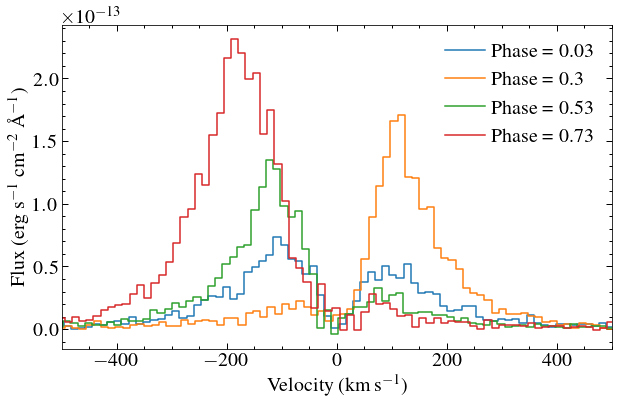

In [94]:
args = np.argsort(phase_fit)
phaseord = phase_fit[args]
plt.figure(figsize=(9, 6))
x1ds_phase = np.array(x1ds)[args] 

lya_system = gamma.to(u.AA,  equivalencies=u.doppler_optical(lya*u.AA))

for i, x in enumerate(x1ds_phase):
    print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
#     v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya_system))
    plt.step(v, f, where='mid', label='Phase = {}'.format(phaseord[i]))
#     plt.plot(v, f, label='Phase = {}'.format(phaseord[i]))
plt.xlim(-500, 500)
plt.legend()
plt.xlabel('Velocity (km\,s$^{-1}$)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
# plt.savefig('plots/eg_uma_all_lya.pdf', dpi=150)
# plt.savefig('plots/eg_uma_all_lya.png', dpi=150)

/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua2010_x1d.fits -152
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehub3010_x1d.fits -3
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua4010_x1d.fits -48.0
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua1010_x1d.fits 87.0


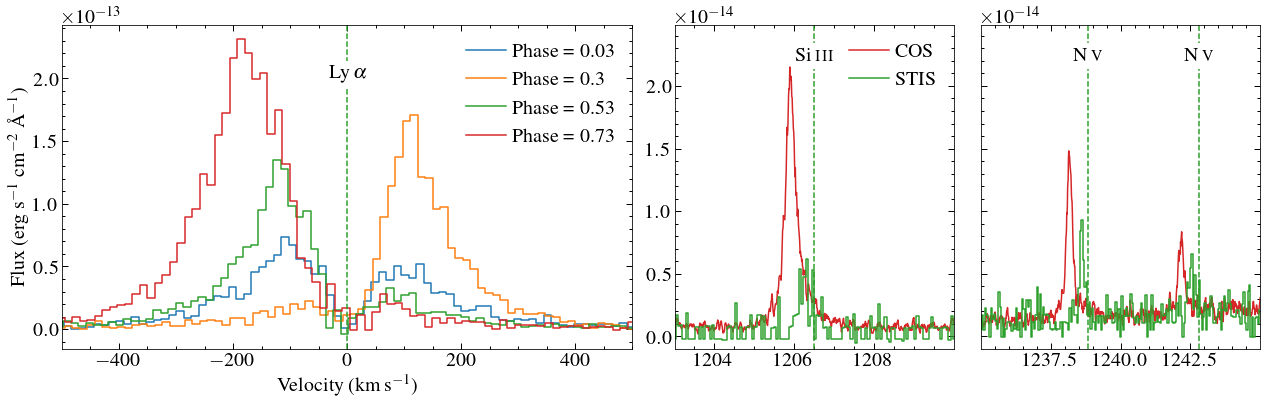

In [95]:
dv_labs = [-152,-3, -48.0, 87.0]
dve_labs = [3.5, 5, 3.0, 7.4]


plt.figure(figsize=(18,6))
plt.subplot(121)
for i, x in enumerate(x1ds_phase):
    print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
    plt.step(v, f, where='mid', label='Phase = {}'.format(phaseord[i]))
#     plt.plot(v, f, label='Phase = {}'.format(phaseord[i]))
plt.xlim(-500, 500)
plt.legend()
plt.xlabel('Velocity (km\,s$^{-1}$)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(loc=1)
# plt.xlim(1213.1, 1217.9)
plt.axvline(0, c='C2', ls='--')
plt.annotate(r'Ly\,$\alpha$',(0, 2e-13), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))


data = fits.getdata(x1ds_phase[2],1)[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']
# fs = convolve(fs,Box1DKernel(2))

mask = (wc1 > ws[0]) & (wc1 < ws[-1])


plt.subplot(143)
plt.plot(wc1[mask], fc1[mask], label='COS', c='C3')
plt.step(ws, fs, where='mid', label='STIS',c='C2')
plt.xlim(1203.01, 1209.99)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]
plt.annotate(names[0],(lines[0], 2.2e-14), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
plt.legend()



plt.subplot(144)
plt.plot(wc1[mask], fc1[mask], c='C3')
plt.step(ws, fs, where='mid', c='C2')
plt.xlim(1235.01, 1244.99)
plt.ylim(-1e-15, 2.49e-14)
[plt.axvline(line, c='C2', ls='--') for line in lines]
[plt.annotate(name,(line, 2.2e-14), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none')) for name, line in zip(names[1:], lines[1:])]

plt.yticks(visible=False)


plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig('plots/eg_uma_1stlook.png', dpi=150)

MovieWriter imagemagick unavailable; using Pillow instead.


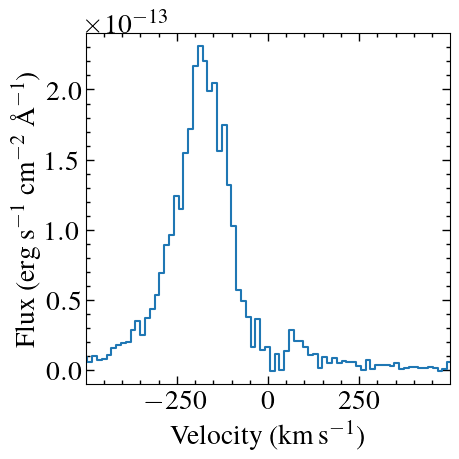

In [96]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(5, 5))
fig.set_dpi(100)

ax = plt.axes(xlim=(-499, 499), ylim=(-0.1e-13, 2.4e-13))

# ax.set_ylim(-0.1e-13, 2.4e-13)
# ax.set_xlim(-500, 500)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Velocity (km\,s$^{-1}$)')

line1, = ax.step([0,0],[0,0], where='mid')

def update(i):
    data = fits.getdata(x1ds_phase[i], 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
    line1.set_xdata(v)
    line1.set_ydata(f)
    return ax, line1
fig.set_tight_layout(True)
fig.patch.set_facecolor('w')

anim = FuncAnimation(fig, update, frames=np.arange(len(x1ds_phase)), interval=300)
anim.save('plots/eguma_lya.gif', dpi=100, writer='imagemagick')
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


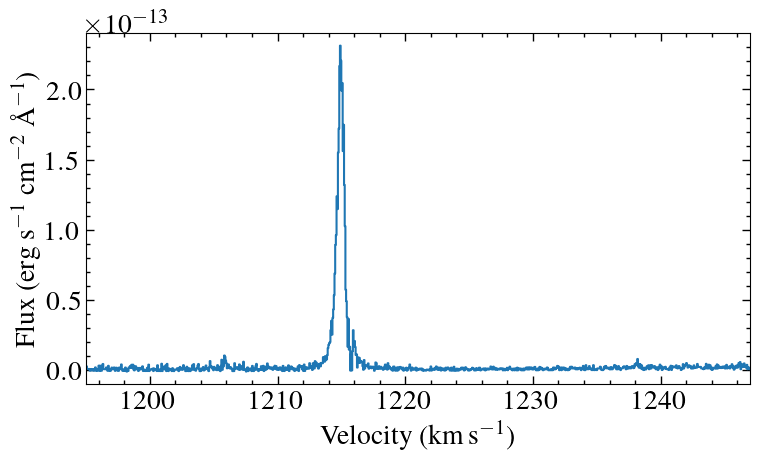

In [97]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(8, 5))
fig.set_dpi(100)

ax = plt.axes(xlim=(1195, 1247), ylim=(-0.1e-13, 2.4e-13))
# plt.xlim(1195, 1247)
# ax.set_ylim(-0.1e-13, 2.4e-13)
# ax.set_xlim(-500, 500)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Velocity (km\,s$^{-1}$)')

line1, = ax.step([0,0],[0,0], where='mid')

def update(i):
    data = fits.getdata(x1ds_phase[i], 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
    line1.set_xdata(w)
    line1.set_ydata(f)
    return ax, line1
fig.set_tight_layout(True)
fig.patch.set_facecolor('w')

anim = FuncAnimation(fig, update, frames=np.arange(len(x1ds_phase)), interval=300)
anim.save('plots/eguma_stis.gif', dpi=100, writer='imagemagick')
plt.show()

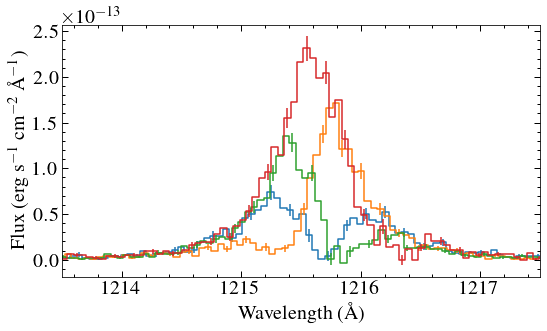

In [98]:
#stellar rest frame

plt.figure(figsize=(8,5))
for i, x in enumerate(x1ds_phase):
    # if i != 1:
   # print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ws = (-1*deltavs[args][i]*u.km/u.s).to(u.AA, equivalencies=u.doppler_optical(w*u.AA))

    plt.step(ws, f, where='mid', label='Phase = {}'.format(phaseord[i]), c='C{}'.format(i))
    plt.errorbar(ws, f, yerr=e, errorevery=3, c='C{}'.format(i), ls='none')

#     plt.plot(v, f, label='Phase = {}'.format(phaseord[i]))
plt.xlim(1213.5, 1217.5)
# plt.xlim(1216.3, 1217.1)
# plt.ylim(-0.1e-14, 0.5e-13)
# plt.legend()
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
# plt.savefig('plots/eg_uma_all_lya.pdf', dpi=150)
# plt.savefig('plots/eg_uma_stellar_frame.png', dpi=150)

/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua2010_x1d.fits -152
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehub3010_x1d.fits -3
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua4010_x1d.fits -48.0
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua1010_x1d.fits 87.0


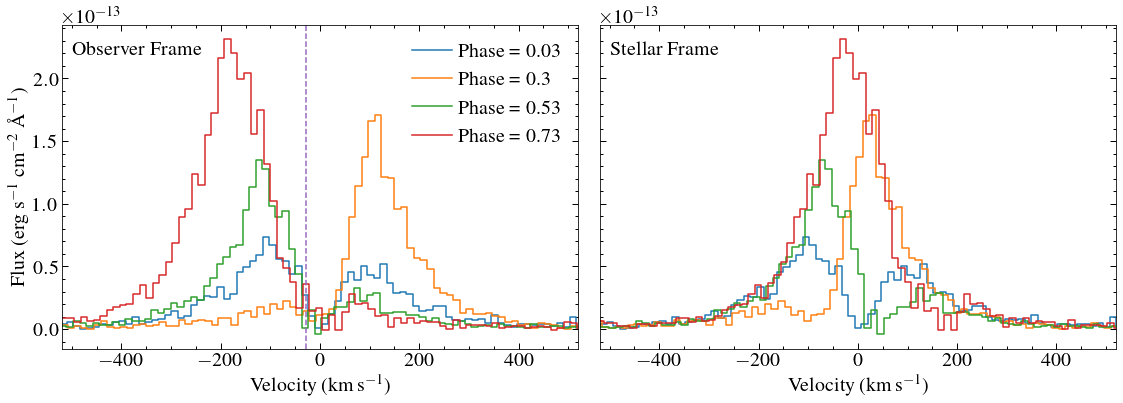

In [99]:

plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, x in enumerate(x1ds_phase):
    print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
#     v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya_system))
    plt.step(v, f, where='mid', label='Phase = {}'.format(phaseord[i]))
#     plt.plot(v, f, label='Phase = {}'.format(phaseord[i]))
plt.xlim(-520, 520)
plt.legend()
plt.xlabel('Velocity (km\,s$^{-1}$)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.annotate('Observer Frame', (0.02, 0.95), xycoords='axes fraction', va='top', ha='left')
plt.axvline(gamma.value, ls='--', c='C4')


#stellar rest frame
plt.subplot(122)
for i, x in enumerate(x1ds_phase):
   # print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ws = (-1*deltavs[args][i]*u.km/u.s).to(u.AA, equivalencies=u.doppler_optical(w*u.AA))
    v = (ws).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
    plt.step(v, f, where='mid', label='Phase = {}'.format(phaseord[i]))
#     plt.plot(v, f, label='Phase = {}'.format(phaseord[i]))
plt.xlim(-520, 520)
plt.yticks(visible=False)
plt.annotate('Stellar Frame', (0.02, 0.95), xycoords='axes fraction', va='top', ha='left')
# plt.legend()
plt.xlabel('Velocity (km\,s$^{-1}$)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.savefig('plots/eg_uma_lya_all_lines.pdf', dpi=150)

Nice emisson line plot

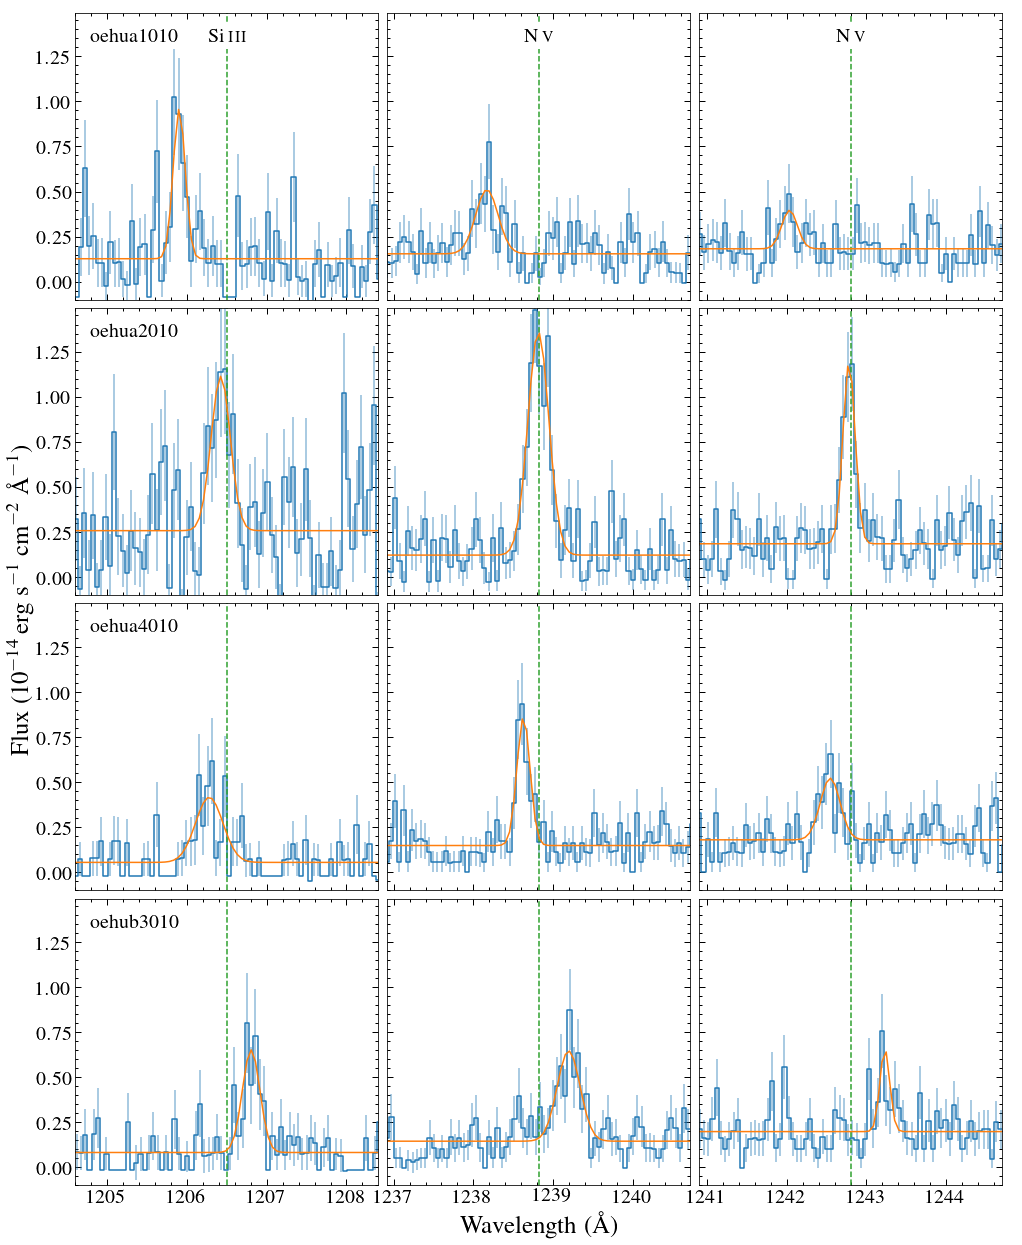

In [100]:
# plt.figure(figsize = (15, 20))
names = ['Si\,{\sc iii}', 'N\,{\sc v}', 'N\,{\sc v}']

fig, axes = plt.subplots(4, 3,figsize=(15,18))

guess_dv = (np.array([-180, 0, -60, 50])*u.km/u.s)
for i, x in enumerate(np.array(x1ds)):
    data = fits.getdata(x, 1)[0]
    hdr = fits.getheader(x, 1)
    # print(hdr['ROOTNAME'])
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    stis_mask = (w < lines[0]-2) | (w > lines[0]+2) & (w < 1210) | (w > 1220) & (w < lines[1]-2) | (w > lines[1]+2) & (w < lines[2]-2) | (w > lines[2]+2) 
    wi, fi, ei = w[stis_mask], f[stis_mask], e[stis_mask]
   # poly_init = models.Polynomial1D(2)
  #  poly_fit =  fitting.LinearLSQFitter()(poly_init, wi, fi)#, weights = 1/ei)
 #   f = f - poly_fit(w)
    
    for j, line in enumerate(lines): #nv 1242 is only barely detected
        plt.subplot(4, 3, j+1+len(lines*i))
        guess_line = guess_dv[i].to(u.AA,  equivalencies=u.doppler_optical(line*u.AA)).value
#         print(guess_line)
        mask = (w > line-2) & (w < line+2)
        wline, fline, eline = w[mask], f[mask], e[mask]
        plt.step(wline, fline*1e14, where='mid')
        plt.errorbar(wline, fline*1e14, yerr=eline*1e14, ls='none', c='C0', alpha =0.5)
        # plt.step(wline, eline, where='mid')
        plt.axvline(line, ls='--', c='C2')
        # plt.axvline(guess_line, ls='--', c='C3')
        gg_init = models.Const1D(0)+models.Gaussian1D(1e-14, guess_line, 0.1)
        gg_fit = fitter(gg_init, wline, fline, maxiter=100000)
        plt.xlim(line-1.9, line+1.9)
        if i != len(x1ds)-1:
            plt.xticks(visible=False)
        plt.ylim(-0.1, 1.49)
        if j != 0:
            plt.yticks(visible=False)
        if i == 0:
            plt.annotate(names[j], (line, 0.95), xycoords=('data', 'axes fraction'), ha='center', va='top', bbox=dict(facecolor='white', edgecolor='none'))
        if j == 0:
            plt.annotate(hdr['ROOTNAME'], (0.05, 0.95), xycoords = 'axes fraction', ha='left', va='top', bbox=dict(facecolor='white', edgecolor='none'))
        
        plt.plot(wline, gg_fit(wline)*1e14, c='C1')
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.ylabel('Flux ($10^{-14}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25, labelpad=12)
plt.xlabel('Wavelength (\AA)', size=25)
plt.tight_layout()
plt.subplots_adjust(hspace=0.03, wspace=0.03)
plt.savefig('plots/eg_uma_stis_lines.pdf')

oehua1010
-153.1062269517864 7.008987569483352
-157.34506656618257 8.202673444314257
-184.40958157385404 14.214631498496146


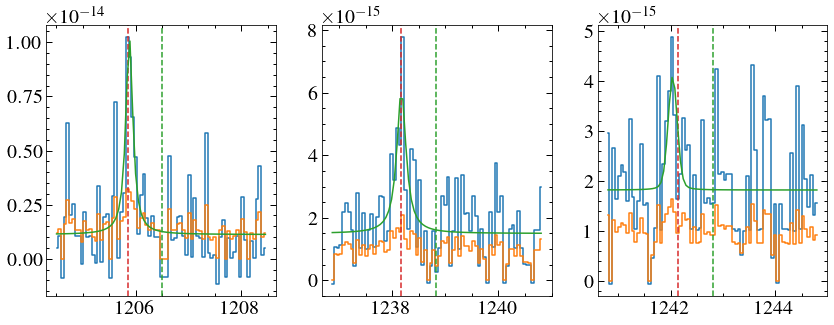

-158.53161506515784 6.998195306184922
oehua2010
-19.36155840702782 9.457966171112801
-0.8262705376021118 2.571798569766427
-8.919169368091175 2.946402199557679


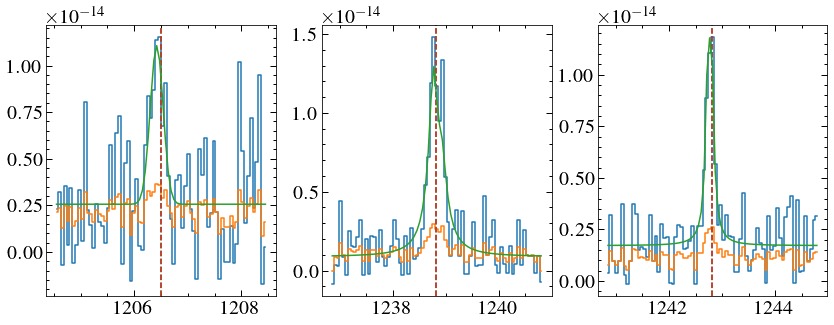

-4.931431831551659 3.476049869663034
oehua4010
-54.12809311217795 9.351359464340241
-48.24495918746517 3.9165625912696207
-62.408494672437314 9.170698362135525


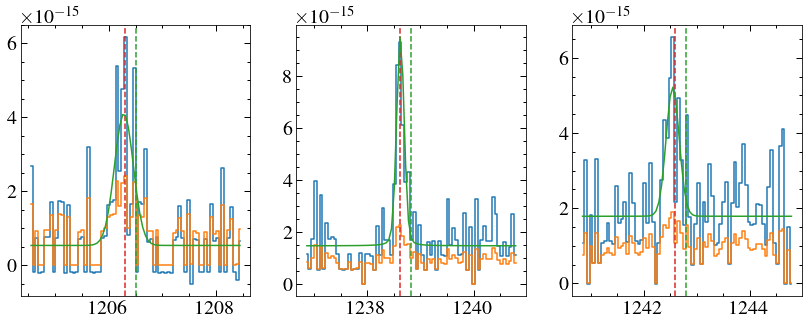

-50.90755803749954 3.4877647659420985
oehub3010
75.4111182311685 5.78923589864042
89.31898215107968 6.187963342499991
99.89491464694508 10.534784065987324


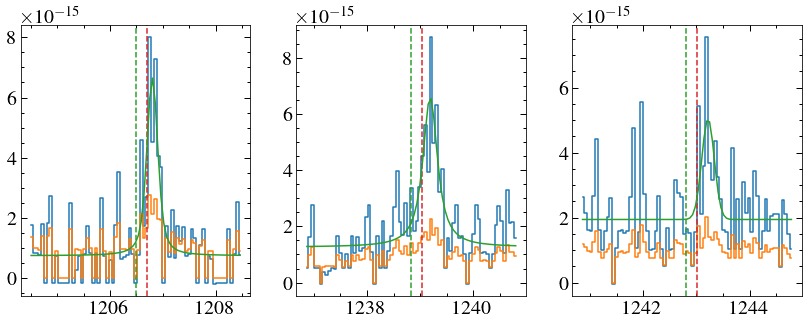

84.39811687800574 6.330042040912368


In [101]:
def gauss_flux(amp, std, off, ae, se, oe):
    """
    Calcualates the flux and error of a Gaussian with amplitude and stddev amp and std, with offset off
    """
    off_err = 0
    if off != 0.0:
        amp += (-1*off)
        off_err = (oe/off)**2
        
    flux = ((2*np.pi)**0.5) * amp * std
    error = flux * (((ae/amp)**2)+((se/std)**2)+off_err)**0.5
    return flux, error



def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error

deltavs = []
deltav_errs = []

line_fluxes = np.ndarray(shape=(len(x1ds), len(lines)))
line_errors = np.ndarray(shape=(len(x1ds), len(lines)))

line_dvs = np.ndarray(shape=(len(x1ds), len(lines)))
line_dves = np.ndarray(shape=(len(x1ds), len(lines)))

dates = []
v_helios = []

exptimes = []

guess_dv = np.array([-160, 0, -50, 50])*u.km/u.s
for i, x in enumerate(x1ds):
    data = fits.getdata(x, 1)[0]
    hdr = fits.getheader(x, 1)
    print(hdr['ROOTNAME'])
    tstart, tend = (hdr['EXPSTART']), (hdr['EXPEND']) #mjd
    exptimes.append(hdr['EXPTIME'])
    v_helios.append(hdr['V_HELIO'])
    dates.append((tstart+tend)/2)
    
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    stis_mask = (w < lines[0]-2) | (w > lines[0]+2) & (w < 1210) | (w > 1220) & (w < lines[1]-2) | (w > lines[1]+2) & (w < lines[2]-2) | (w > lines[2]+2) 
    wi, fi, ei = w[stis_mask], f[stis_mask], e[stis_mask]
    poly_init = models.Polynomial1D(2)
    poly_fit =  fitting.LinearLSQFitter()(poly_init, wi, fi)#, weights = 1/ei)
 #   f = f - poly_fit(w)
    
    dvs = []
    dves = []
    for j, line in enumerate(lines): #nv 1242 is only barely detected
        plt.subplot(1, 3, j+1)
        guess_line = guess_dv[i].to(u.AA,  equivalencies=u.doppler_optical(line*u.AA)).value
#         print(guess_line)
        mask = (w > line-2) & (w < line+2)
        wline, fline, eline = w[mask], f[mask], e[mask]
        plt.step(wline, fline, where='mid')
        plt.step(wline, eline, where='mid')
        plt.axvline(line, ls='--', c='C2')
        plt.axvline(guess_line, ls='--', c='C3')
        # gg_init = models.Const1D(0)+models.Gaussian1D(1e-14, guess_line, 0.1)
        # gg_fit = fitter(gg_init, wline, fline, maxiter=100000)
        
        v_init = models.Const1D(0)+models.Voigt1D(x_0=guess_line, amplitude_L=1e-14, fwhm_L=0.1, fwhm_G=0.1)
        v_fit = fitter(v_init, wline, fline, maxiter=100000)
        plt.plot(wline, v_fit(wline))
      #  print(gg_fit)
#         fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
       # print(fit_e)
        # plt.plot(wline, gg_fit(wline))
        rest_lam = line*u.AA
        obs_lam = v_fit[1].x_0*u.AA
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
        
        if type(fitter.fit_info['param_cov']) == np.ndarray:
            fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
            # off, oe = v_fit[0].amplitude, fit_e[0]
           # amp, ae = gg_fit[1].amp, fit_e[1],
           # std, se = gg_fit[1].stddev, fit_e[2]
           # f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
        
            eup = (obs_lam+fit_e[1]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
            edo = (obs_lam-fit_e[1]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
            dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s    
            # line_fluxes[i, j] = f_l
            # line_errors[i, j] = e_l
            line_dvs[i, j] = dv.value
            line_dves[i, j] = dve.value

            
        else:
            # line_fluxes[i, j] = -1.0
            # line_errors[i, j] = -1.0
            line_dvs[i, j] = -1.0
            line_dves[i, j] = -1.0
            
        print(line_dvs[i,j], line_dves[i,j])
            
        # v_init = models.Const1D(0)+models.Voigt1D(x_0=guess_line, amplitude_L=1e-14, fwhm_L=0.1, fwhm_G=0.1)
        # v_fit = fitter(v_init, wline, fline, maxiter=100000)
        # plt.plot(wline, v_fit(wline))
        
      # 
        
#         obs_line = gg_fit[1].mean.value*u.AA
#         dv = obs_line.to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
#        # print(fit_e)
#         eup = (obs_line+fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
#         edo = (obs_line-fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
#         dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s
# #         print(dv, dve)
#         dvs.append(dv.value)
#         dves.append(dve.value)
        
#         line_flux, line_fluxerr = gauss_flux(gg_fit[1].amplitude, gg_fit[1].stddev, gg_fit[0].amplitude, fit_e[1], fit_e[3], fit_e[0])
#        # print(line_flux, line_fluxerr)
#         line_fluxes[i, j] = line_flux
#         line_errors[i, j] = line_fluxerr
#         line_dvs[i, j] = dv.value
#         line_dves[i, j] = dve.value
      #  print(line_fluxes) 
    plt.show()
    dv_spec, dve_spec = dv_average(line_dvs[i][line_dvs[i]!=-1.0], line_dves[i][line_dvs[i]!=-1.0])
    deltavs.append(dv_spec)
    deltav_errs.append(dve_spec)
    print(dv_spec, dve_spec)
       
dates, deltavs, deltav_errs = np.array(dates), np.array(deltavs), np.array(deltav_errs)
     

In [102]:
# #IFMR
# # Mf = (0.080 ± 0.016) × Mi + (0.489 ± 0.030)
# Mf =0.514
# Mi = (Mf - 0.489)/0.08
# Mi

# # Mf = (0.187 ± 0.061) × Mi + (0.184 ± 0.199)
# Mi = (Mf - 0.184)/0.187
# Mi

#age estimate
Mi = 2
ts = 10e9
ti = ts*Mi**(-2.5)
ti

1767766952.966369

In [103]:
#irradiation https://arxiv.org/pdf/2203.05901.pdf, rebassa-mansergasetal13-1
twd = 12599*u.K
tmd = 3250*u.K
rwd = 0.0144*u.Rsun
a = 3.27*u.Rsun
r_int = (tmd/twd)**4 * (a/rwd)**2
print(1/r_int)

0.004379659413591057


Where are the airglow lines?

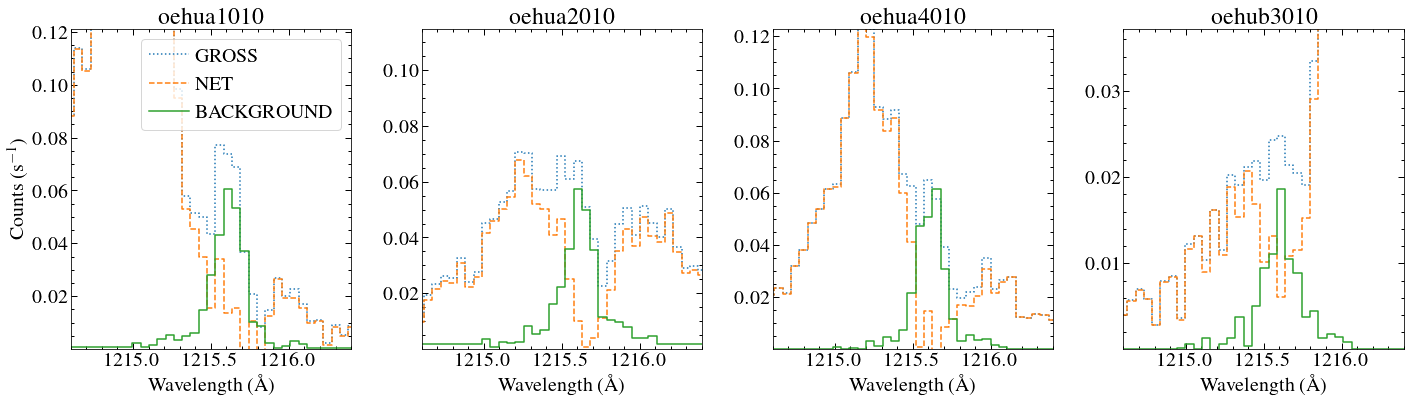

In [104]:
plt.figure(figsize=(20,6))
plt.facecolor='w'
for i, x in enumerate(x1ds):
    plt.subplot(1, 4, i+1)
    data = fits.getdata(x, 1)[0]
    root = fits.getheader(x, 1)['ROOTNAME']
    # plt.step(data['WAVELENGTH'],data['FLUX'])
    # plt.step(data['WAVELENGTH'],data['ERROR'])
    plt.step(data['WAVELENGTH'],data['GROSS'], label='GROSS', where='mid', ls=':')
    plt.step(data['WAVELENGTH'],data['NET'], label='NET', where='mid', ls='--')
    plt.step(data['WAVELENGTH'],data['BACKGROUND'], label='BACKGROUND', where='mid')
    plt.xlabel('Wavelength (\AA)')
    if i == 0:
        plt.ylabel('Counts (s$^{-1}$)')
        plt.legend(frameon=True)
    plt.xlim(1214.6, 1216.4)
    plt.ylim(0.0001, max(data['BACKGROUND'])*2)
    plt.facecolor='w'

    plt.title(root)

    # plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()


In [105]:
# 1206.499 Angstrom 1205.9017662592248 Angstrom
# 1238.821 Angstrom 1238.1692390069052 Angstrom
# 1242.804 Angstrom 1242.0347558193682 Angstrom
v1 = (3e8 * ((1205.902-1206.499)/1206.499))
v2 = (3e8 * ((1238.169-1238.821)/1238.821))
v3 = (3e8 * ((1242.034-1242.804)/1242.804))
print(np.mean([v1, v2]))

-153169.0506282153


(-0.49, 0.49)

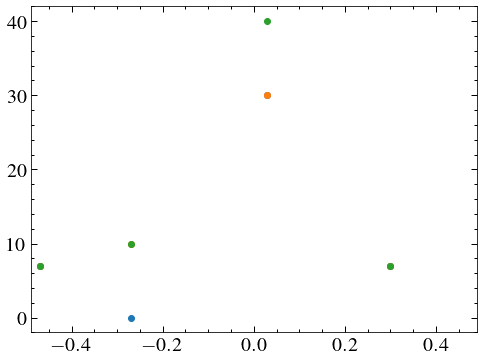

In [106]:

plt.figure(figsize=(8,6))
phase_adj = [] #phases from -0.5 to 0.5

for phase in phaseord:
    if phase > 0.5:
        phase_adj.append(phase-1)
    else:
        phase_adj.append(phase)
        

for i in range(len(lines)):
    plt.errorbar(phase_adj, line_fluxes[:,i][args], yerr=line_errors[:,i][args], ls='none', marker='o', label = '{}\,{}\,\AA'.format(names[i], lines[i]))

plt.xlim(-0.49, 0.49)

In [107]:
mrd = 0.42*u.Msun
rrd = 0.45*u.Rsun
logg = (const.G.to(u.cm**3/u.g/u.s**2)*mrd.to(u.g))/(rrd.to(u.cm))**2
print(logg)
print(np.log10(logg.value))

56871.13426967738 cm / s2
4.754891890150346


Text(0.5, 0, 'Wavelength (\\AA)')

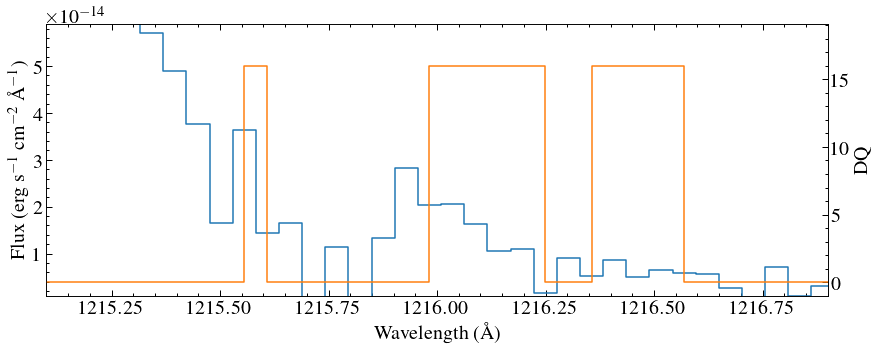

In [108]:
fig, ax = plt.subplots()
data = fits.getdata(x1ds[0], 1)[0]
plt.step(data['Wavelength'], data['Flux'], where='mid')
ax2= ax2=ax.twinx()
plt.xlim(1215.1, 1216.9)
ax.set_ylim(0.01e-13, 0.59e-13)
ax2.step(data['Wavelength'],data['DQ'], c='C1')
ax2.set_ylim(-1,19.1)
ax2.set_ylabel('DQ')
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')

(-1.0, 20.0)

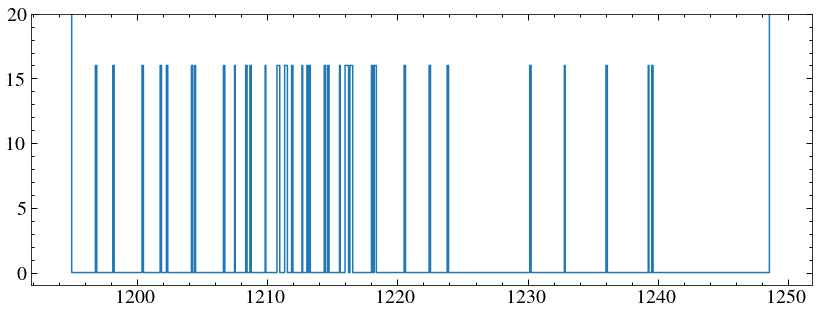

In [109]:
plt.step(data['Wavelength'],data['DQ'])
plt.ylim(-1, 20)

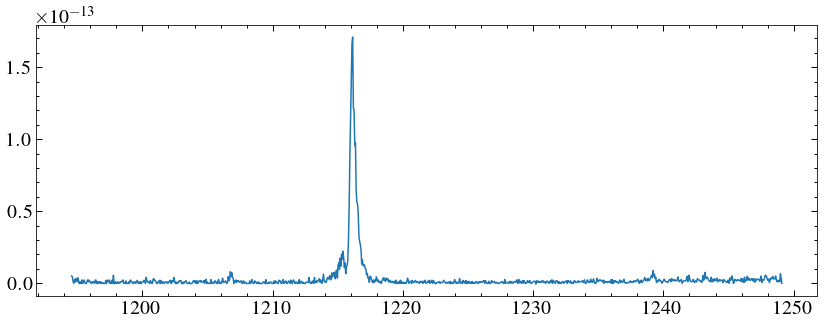

In [110]:
plt.plot(w, f)

Adding a single specturm to the profiles plot

/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua2010_x1d.fits -152
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehub3010_x1d.fits -3
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua4010_x1d.fits -48.0
/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua1010_x1d.fits 87.0


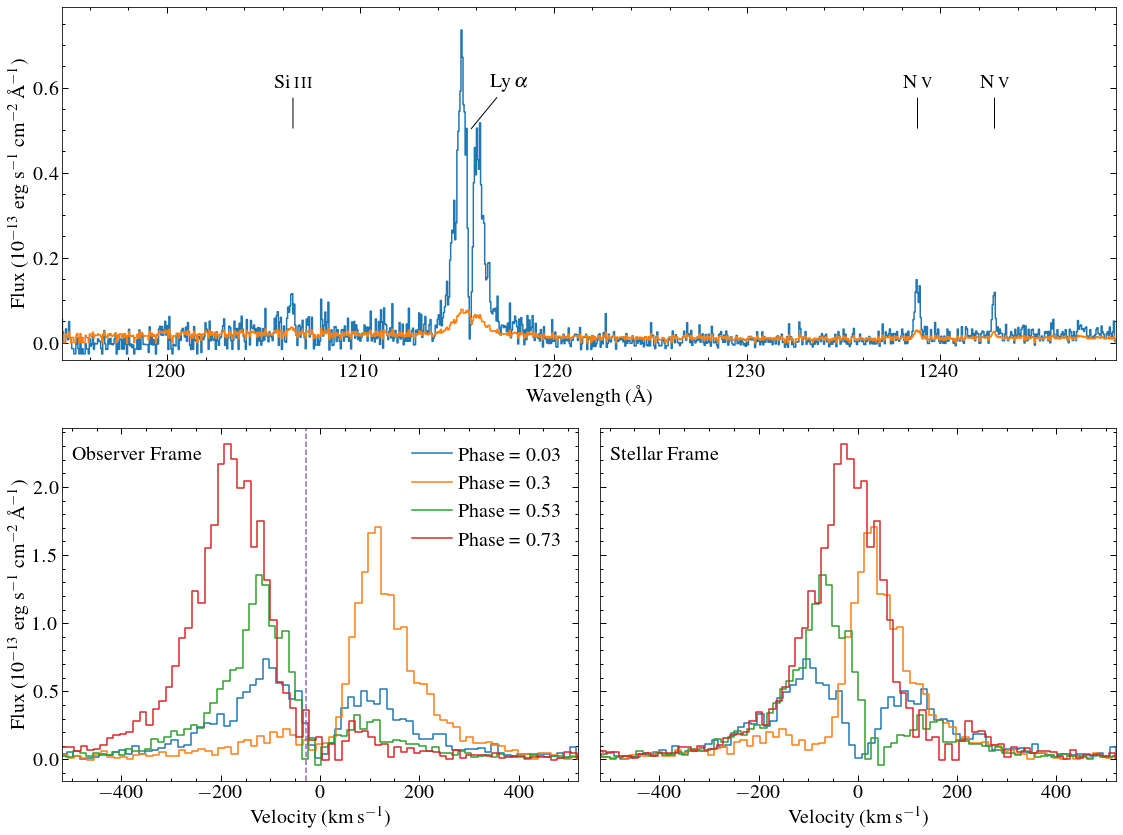

In [111]:

fscale = 1e13

plt.figure(figsize=(16, 12))

plt.subplot(211)
for i, x in enumerate(x1ds_phase[0:1]):
    # print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    # v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
#     v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya_system))
    plt.step(w, f*fscale, where='mid') #label='Phase = {}'.format(phaseord[i]))
    plt.step(w, e*fscale, where='mid')
plt.ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlabel('Wavelength (\AA)')
plt.xlim(w[0], w[-1])
plt.ylim(-0.04, 0.79)
# plt.yscale('log')



names = ['Si\,{\sc iii}', r'Ly\,$\alpha$','N\,{\sc v}', 'N\,{\sc v}']
lines = [1206.51, 1215.67, 1238.821,1242.804]
for name, line in zip(names, lines):
    if line == 1215.67:
        plt.annotate(name,(line, 0.5), xytext=(line+2, 0.6),arrowprops=dict(arrowstyle='-'), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none', alpha =0.5))
    else:
    # plt.annotate('',(line, 0.5), xytext=(line, 0.58),arrowprops=dict(arrowstyle='-'), horizontalalignment='center')
        plt.annotate(name,(line, 0.5), xytext=(line, 0.6),arrowprops=dict(arrowstyle='-'), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none', alpha =0.5))

    
    

plt.subplot(223)
for i, x in enumerate(x1ds_phase):
    print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
#     v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya_system))
    plt.step(v, f*fscale, where='mid', label='Phase = {}'.format(phaseord[i]))
#     plt.plot(v, f, label='Phase = {}'.format(phaseord[i]))
plt.xlim(-520, 520)
plt.legend()
plt.xlabel('Velocity (km\,s$^{-1}$)')
plt.ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.annotate('Observer Frame', (0.02, 0.95), xycoords='axes fraction', va='top', ha='left')
plt.axvline(gamma.value, ls='--', c='C4')


#stellar rest frame
plt.subplot(224)
for i, x in enumerate(x1ds_phase):
   # print(x, dv_labs[i])
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ws = (-1*deltavs[args][i]*u.km/u.s).to(u.AA, equivalencies=u.doppler_optical(w*u.AA))
    v = (ws).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
    plt.step(v, f*fscale, where='mid', label='Phase = {}'.format(phaseord[i]))
#     plt.plot(v, f, label='Phase = {}'.format(phaseord[i]))
plt.xlim(-520, 520)
plt.yticks(visible=False)
plt.annotate('Stellar Frame', (0.02, 0.95), xycoords='axes fraction', va='top', ha='left')
# plt.legend()
plt.xlabel('Velocity (km\,s$^{-1}$)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.savefig('plots/eg_uma_lya_stis_spec.pdf', dpi=150)

In [112]:
# fits.getheader(x1ds[0])